In [175]:
# Cell 1: Setup and Data Loading
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Polygon, Patch

GNCA_DIR = "../reproduction/inference-gnca"
PT_DIR = "../reproduction/inference-pytorch"

def load_eval_csvs_from_dir(base_dir):
    """Load all eval_metrics.csv files from subdirectories"""
    dfs = {}
    base_path = Path(base_dir)
    
    for csv_path in base_path.glob("**/metrics.csv"):
        # Extract run identifier from path (parent directory name)
        run_name = csv_path.parent.parent.name + "_" + csv_path.parent.name
        try:
            df = pd.read_csv(csv_path)
            dfs[run_name] = df
        except Exception as e:
            print(f"Failed to load {csv_path}: {e}")
    
    return dfs

# Load data from both directories
gnca_dfs = load_eval_csvs_from_dir(GNCA_DIR)
pt_dfs = load_eval_csvs_from_dir(PT_DIR)

print(f"TensorFlow runs: {len(gnca_dfs)} - {list(gnca_dfs.keys())[:5]}...")
print(f"PyTorch runs: {len(pt_dfs)} - {list(pt_dfs.keys())[:5]}...")

# Find common runs (same target/mode combinations)
gnca_keys = set(gnca_dfs.keys())
pt_keys = set(pt_dfs.keys())
common_keys = gnca_keys & pt_keys

print(f"Common runs: {len(common_keys)}")
print(f"Missing in TensorFlow: {pt_keys - gnca_keys}")
print(f"Missing in PyTorch: {gnca_keys - pt_keys}")

TensorFlow runs: 600 - ['xsmiley_persistent_run_012', 'xsmiley_persistent_run_015', 'xsmiley_persistent_run_014', 'xsmiley_persistent_run_013', 'xsmiley_persistent_run_007']...
PyTorch runs: 300 - ['smiley_persistent_run_012', 'smiley_persistent_run_015', 'smiley_persistent_run_014', 'smiley_persistent_run_013', 'smiley_persistent_run_007']...
Common runs: 300
Missing in TensorFlow: set()
Missing in PyTorch: {'xfish_persistent_run_009', 'xsmiley_regenerating_run_009', 'xfish_regenerating_run_007', 'xlizard_regenerating_run_006', 'xfish_growing_run_001', 'xladybug_persistent_run_018', 'xfish_persistent_run_015', 'xfish_growing_run_002', 'xsmiley_growing_run_007', 'xsmiley_growing_run_001', 'xweb_growing_run_019', 'xladybug_persistent_run_008', 'xweb_regenerating_run_020', 'xlizard_regenerating_run_018', 'xfish_regenerating_run_009', 'xlizard_growing_run_002', 'xfish_growing_run_006', 'xladybug_persistent_run_007', 'xweb_growing_run_007', 'xladybug_growing_run_012', 'xsmiley_growing_run_

In [176]:
# Cell 2: Helper Functions
def resample_to_common_grid(x1, y1, x2, y2, n=2000):
    xmin, xmax = max(x1.min(), x2.min()), min(x1.max(), x2.max())
    grid = np.linspace(xmin, xmax, n)
    y1g = np.interp(grid, x1, y1)
    y2g = np.interp(grid, x2, y2)
    return grid, y1g, y2g

def iqr_overlap_fraction(x, lo1, hi1, lo2, hi2, n=2000):
    g, lo1g, hi1g = resample_to_common_grid(x, lo1, x, hi1, n)
    _, lo2g, hi2g = resample_to_common_grid(x, lo2, x, hi2, n)
    overlap = np.maximum(0.0, np.minimum(hi1g, hi2g) - np.maximum(lo1g, lo2g))
    is_overlap = overlap > 0
    return is_overlap.mean(), g, overlap

def time_to_threshold(x, y, thresh):
    """First step where y <= thresh; returns np.nan if never crosses."""
    if (y <= thresh).any():
        idx = np.argmax(y <= thresh)
        return x[idx]
    return np.nan

def closeness_metrics(pt_steps, m_pt, gnca_steps, m_gnca,
                      lo_pt=None, hi_pt=None, lo_gnca=None, hi_gnca=None,
                      thresh=1e-3, n_grid=2000):
    # 1) common grid
    g, m_pt_g, m_gnca_g = resample_to_common_grid(pt_steps, m_pt, gnca_steps, m_gnca, n=n_grid)
    diff = m_pt_g - m_gnca_g
    adiff = np.abs(diff)

    # 2) aggregate gaps
    aag = np.trapz(adiff, g) / (g[-1] - g[0])
    rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))
    maxgap = adiff.max()
    step_at_max = g[adiff.argmax()]
    rel_gap_pct = (adiff / (0.5 * (np.abs(m_pt_g) + np.abs(m_gnca_g)))).mean() * 100

    # 3) late-phase gap
    cut = int(0.9 * len(g))
    aag_tail = adiff[cut:].mean()

    # steps 64-96 gap
    mask_64_96 = (g >= 64) & (g <= 96)
    aag_64_96 = adiff[mask_64_96].mean() if mask_64_96.any() else np.nan


    # 4) IQR overlap
    overlap_frac = np.nan
    if lo_pt is not None and hi_pt is not None and lo_gnca is not None and hi_gnca is not None:
        overlap_frac, _, _ = iqr_overlap_fraction(pt_steps, lo_pt, hi_pt, lo_gnca, hi_gnca, n=n_grid)

    # 5) time-to-threshold
    t_pt = time_to_threshold(pt_steps, m_pt, thresh)
    t_gnca = time_to_threshold(gnca_steps, m_gnca, thresh)

    # show here not closeness, but the mean for pytorch and gnca
    # 1 in the 64-96 range
    mask_64_96 = (g >= 64) & (g <= 96)
    pt_mean_64_96 = m_pt_g[mask_64_96].mean() if mask_64_96.any() else np.nan
    gnca_mean_64_96 = m_gnca_g[mask_64_96].mean() if mask_64_96.any() else np.nan

    #2 in the tail
    pt_mean_tail = m_pt_g[cut:].mean()
    gnca_mean_tail = m_gnca_g[cut:].mean()
    
    return {
        "avg_abs_gap": aag,
        "rmse_gap": rmse,
        "max_gap": maxgap,
        "step_at_max_gap": step_at_max,
        "relative_gap_pct": rel_gap_pct,
        "avg_abs_gap_tail": aag_tail,
        "avg_abs_gap_64_96": aag_64_96,
        "iqr_overlap_fraction": overlap_frac,
        "t_to_thresh_pt": t_pt,
        "t_to_thresh_gnca": t_gnca,
        "delta_t_to_thresh": (t_pt - t_gnca) if np.isfinite(t_pt) and np.isfinite(t_gnca) else np.nan,
        "pt_mean_64_96": pt_mean_64_96,
        "gnca_mean_64_96": gnca_mean_64_96,
        "pt_mean_tail": pt_mean_tail,
        "gnca_mean_tail": gnca_mean_tail,
    }

def hatched_band(ax, x, ylo, yhi, *, label=None,
                 facecolor='0.92', edgecolor='0.5', hatch=None,
                 linewidth=0.4, zorder=0, alpha=1.0):
    fb = ax.fill_between(x, ylo, yhi, facecolor=facecolor, edgecolor=edgecolor,
                         linewidth=linewidth, alpha=alpha, zorder=zorder, label=None)

    if hatch:
        xs = np.concatenate([x, x[::-1]])
        ys = np.concatenate([yhi, ylo[::-1]])
        poly = Polygon(np.c_[xs, ys], closed=True, facecolor='none', edgecolor=edgecolor,
                       hatch=hatch, linewidth=linewidth, zorder=zorder + 0.1)
        ax.add_patch(poly)
        proxy = Patch(facecolor=facecolor, edgecolor=edgecolor, hatch=hatch, label=label)
        return proxy
    else:
        fb.set_label(label)
        return fb

In [177]:
# Cell 3: Group runs by target and mode
def parse_run_name(run_name):
    """Extract target and mode from run name"""
    # Assuming format like: fish_growing_run01, web_persistent_run05, etc.
    parts = run_name.split('_')
    if len(parts) >= 2:
        target = parts[0]
        mode = parts[1]
        return target, mode
    return None, None

# Group runs by target and mode
grouped_pt = {}
grouped_gnca = {}

for run_name in common_keys:
    target, mode = parse_run_name(run_name)
    if target and mode:
        key = f"{target}_{mode}"
        
        if key not in grouped_pt:
            grouped_pt[key] = []
            grouped_gnca[key] = []
        
        grouped_pt[key].append(pt_dfs[run_name])
        grouped_gnca[key].append(gnca_dfs[run_name])

print(f"Grouped into {len(grouped_pt)} target/mode combinations:")
for key in sorted(grouped_pt.keys()):
    print(f"  {key}: {len(grouped_pt[key])} runs")

Grouped into 15 target/mode combinations:
  fish_growing: 20 runs
  fish_persistent: 20 runs
  fish_regenerating: 20 runs
  ladybug_growing: 20 runs
  ladybug_persistent: 20 runs
  ladybug_regenerating: 20 runs
  lizard_growing: 20 runs
  lizard_persistent: 20 runs
  lizard_regenerating: 20 runs
  smiley_growing: 20 runs
  smiley_persistent: 20 runs
  smiley_regenerating: 20 runs
  web_growing: 20 runs
  web_persistent: 20 runs
  web_regenerating: 20 runs


In [178]:
# Cell 4: Plot function for inference evaluation
def make_inference_plot(pt_data_list, gnca_data_list, key, metric='loss_mse'):
    """Create comparison plot for a specific target/mode combination"""
    
    # Combine all runs for each implementation
    pt_all_steps = []
    pt_all_values = []
    gnca_all_steps = []
    gnca_all_values = []
    
    max_steps = 0
    for df in pt_data_list:
        if metric in df.columns:
            steps = df['step'].values
            values = df[metric].values
            pt_all_steps.extend(steps)
            pt_all_values.extend(values)
            max_steps = max(max_steps, steps.max())
    
    for df in gnca_data_list:
        if metric in df.columns:
            steps = df['step'].values
            values = df[metric].values
            gnca_all_steps.extend(steps)
            gnca_all_values.extend(values)
            max_steps = max(max_steps, steps.max())
    
    if not pt_all_values or not gnca_all_values:
        print(f"No data for {key} with metric {metric}")
        return
    
    # Create common step grid
    step_grid = np.arange(0, max_steps + 1)
    
    # Aggregate data on common grid for each run
    pt_run_data = []
    gnca_run_data = []
    
    # Process PyTorch runs
    for df in pt_data_list:
        if metric in df.columns:
            steps = df['step'].values
            values = df[metric].values
            interp_values = np.interp(step_grid, steps, values)
            pt_run_data.append(interp_values)
    
    # Process GNCA runs
    for df in gnca_data_list:
        if metric in df.columns:
            steps = df['step'].values
            values = df[metric].values
            interp_values = np.interp(step_grid, steps, values)
            gnca_run_data.append(interp_values)
    
    if not pt_run_data or not gnca_run_data:
        print(f"No interpolated data for {key}")
        return
    
    # Convert to arrays
    pt_array = np.array(pt_run_data)
    gnca_array = np.array(gnca_run_data)
    
    # Calculate statistics
    win = min(51, len(step_grid) // 10)  # Adaptive window size
    
    m_pt = np.median(pt_array, axis=0)
    m_gnca = np.median(gnca_array, axis=0)
    lo_pt = np.percentile(pt_array, 25, axis=0)
    hi_pt = np.percentile(pt_array, 75, axis=0)
    lo_gnca = np.percentile(gnca_array, 25, axis=0)
    hi_gnca = np.percentile(gnca_array, 75, axis=0)
    
    # Smooth if needed
    if win > 1:
        m_pt = pd.Series(m_pt).rolling(win, center=True, min_periods=1).median().values
        m_gnca = pd.Series(m_gnca).rolling(win, center=True, min_periods=1).median().values
        lo_pt = pd.Series(lo_pt).rolling(win, center=True, min_periods=1).median().values
        hi_pt = pd.Series(hi_pt).rolling(win, center=True, min_periods=1).median().values
        lo_gnca = pd.Series(lo_gnca).rolling(win, center=True, min_periods=1).median().values
        hi_gnca = pd.Series(hi_gnca).rolling(win, center=True, min_periods=1).median().values
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # IQR bands
    pt_hb = hatched_band(ax, step_grid, lo_pt, hi_pt, 
                        facecolor='0.65', edgecolor='0.5', linewidth=0.25, 
                        zorder=0, label='PyTorch IQR interval', alpha=0.5)
    gnca_hb = hatched_band(ax, step_grid, lo_gnca, hi_gnca, 
                          facecolor='0.95', edgecolor='0.5', linewidth=0.25, 
                          zorder=-1, label='TensorFlow IQR interval')
    
    # Median lines
    pt_line, = ax.plot(step_grid, m_pt, color='black', linewidth=1, 
                      linestyle='-', label='PyTorch (median)')
    gnca_line, = ax.plot(step_grid, m_gnca, color='black', linewidth=1, 
                        linestyle=(0, (1, 3)), label='TensorFlow (median)')
    
    if metric in ['mse', 'loss']:
        ax.set_yscale('log')
    
    ax.set_xlabel('CA Step')
    ax.set_ylabel(f'{metric.upper()}')
    ax.set_title(f'{key.replace("_", " ").title()} - {metric.upper()} during inference')
    ax.legend(handles=[pt_line, gnca_line, pt_hb, gnca_hb], frameon=True)
    ax.margins(x=0)
    
    plt.tight_layout()
    plt.savefig(f'figures/eval_{metric}_{key}.pdf')
    plt.show()
    
    # Calculate and print metrics
    thresh = 0.01 if metric in ['loss_mse', 'mae'] else 0.95
    metrics = closeness_metrics(
        step_grid, m_pt, step_grid, m_gnca,
        lo_pt=lo_pt, hi_pt=hi_pt, lo_gnca=lo_gnca, hi_gnca=hi_gnca,
        thresh=thresh, n_grid=len(step_grid)
    )
    
    print(f"\nMetrics for {key} ({metric}):")
    for k, v in metrics.items():
        print(f"{k:>22s}: {v}")
    
    return metrics


Analyzing: fish_growing


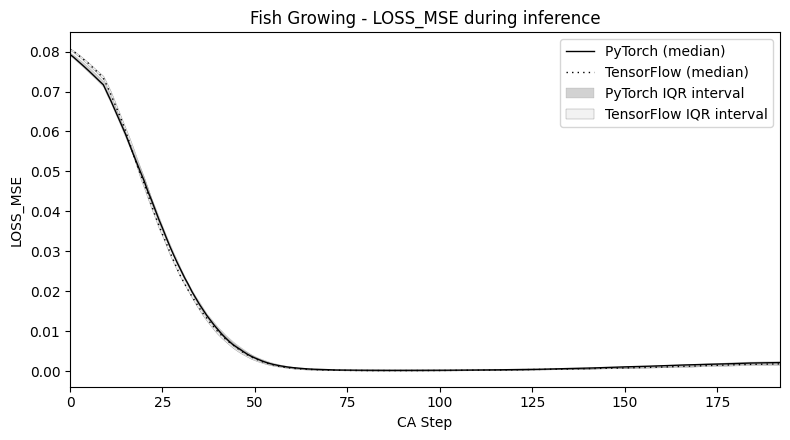


Metrics for fish_growing (loss_mse):
           avg_abs_gap: 0.00038870125566366486
              rmse_gap: 0.0006275799113756799
               max_gap: 0.001799233257770566
       step_at_max_gap: 5.0
      relative_gap_pct: 19.319581422367126
      avg_abs_gap_tail: 0.00031417135905940495
     avg_abs_gap_64_96: 7.755185938685757e-05
  iqr_overlap_fraction: 0.45077720207253885
        t_to_thresh_pt: 41
      t_to_thresh_gnca: 40
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.00026353150447401064
       gnca_mean_64_96: 0.000185979645087153
          pt_mean_tail: 0.0019403328828047535
        gnca_mean_tail: 0.0016261615237453488


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


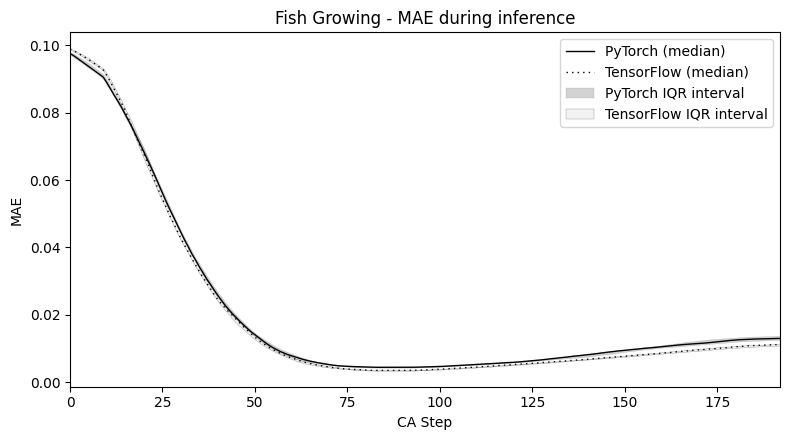


Metrics for fish_growing (mae):
           avg_abs_gap: 0.00123127319663278
              rmse_gap: 0.0013445014939626621
               max_gap: 0.0021836943924427032
       step_at_max_gap: 7.0
      relative_gap_pct: 13.202633556420135
      avg_abs_gap_tail: 0.0019199719419702907
     avg_abs_gap_64_96: 0.0008451845743834303
  iqr_overlap_fraction: 0.24352331606217617
        t_to_thresh_pt: 56
      t_to_thresh_gnca: 55
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.004783544837581778
       gnca_mean_64_96: 0.003938360263198347
          pt_mean_tail: 0.012526511657051695
        gnca_mean_tail: 0.010606539715081404


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


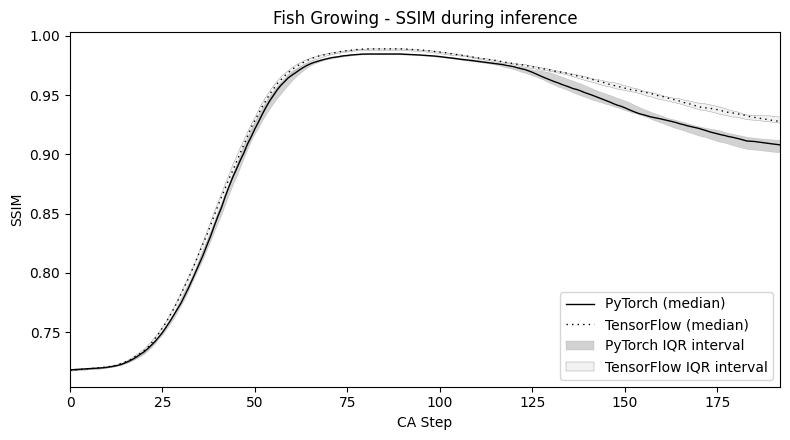

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_growing (ssim):
           avg_abs_gap: 0.008418061920572917
              rmse_gap: 0.01080635745430855
               max_gap: 0.02128313500000001
       step_at_max_gap: 182.0
      relative_gap_pct: 0.9081437915315038
      avg_abs_gap_tail: 0.020360893625000025
     avg_abs_gap_64_96: 0.004185932878787876
  iqr_overlap_fraction: 0.2849740932642487
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9828622283333335
       gnca_mean_64_96: 0.9870481612121211
          pt_mean_tail: 0.9126741700000001
        gnca_mean_tail: 0.933035063625


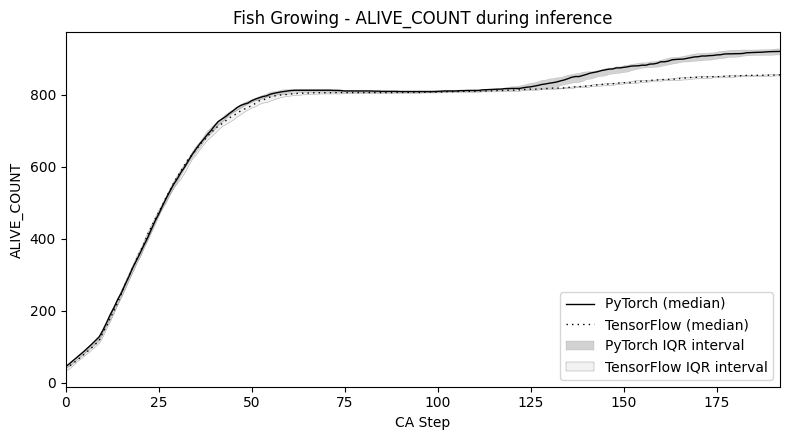

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_growing (alive_count):
           avg_abs_gap: 19.529947916666668
              rmse_gap: 28.97060965803677
               max_gap: 65.5
       step_at_max_gap: 191.0
      relative_gap_pct: 2.9665396348193167
      avg_abs_gap_tail: 62.5875
     avg_abs_gap_64_96: 4.681818181818182
  iqr_overlap_fraction: 0.3160621761658031
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 810.1060606060606
       gnca_mean_64_96: 805.4242424242424
          pt_mean_tail: 914.825
        gnca_mean_tail: 852.2375


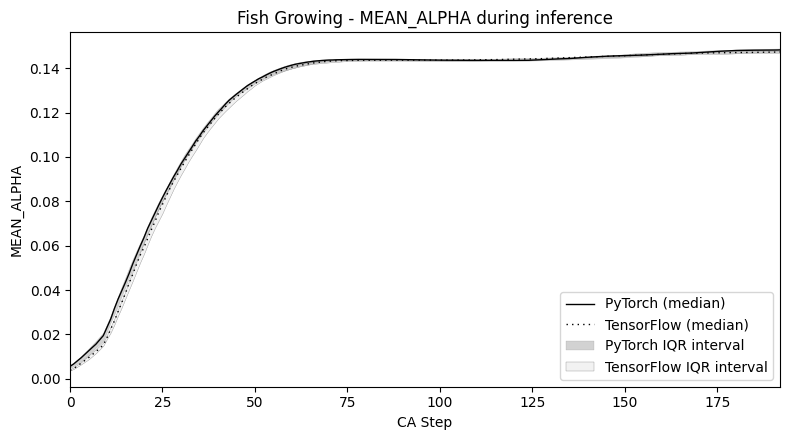

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_growing (mean_alpha):
           avg_abs_gap: 0.0010016033872185933
              rmse_gap: 0.0016271870692649124
               max_gap: 0.005653386004269151
       step_at_max_gap: 13.0
      relative_gap_pct: 2.7952650166553337
      avg_abs_gap_tail: 0.0008543144911527647
     avg_abs_gap_64_96: 0.00039923303958141527
  iqr_overlap_fraction: 0.8808290155440415
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.14380153991056205
       gnca_mean_64_96: 0.14340230687098066
          pt_mean_tail: 0.1480088116601109
        gnca_mean_tail: 0.14715449716895815

Analyzing: fish_persistent


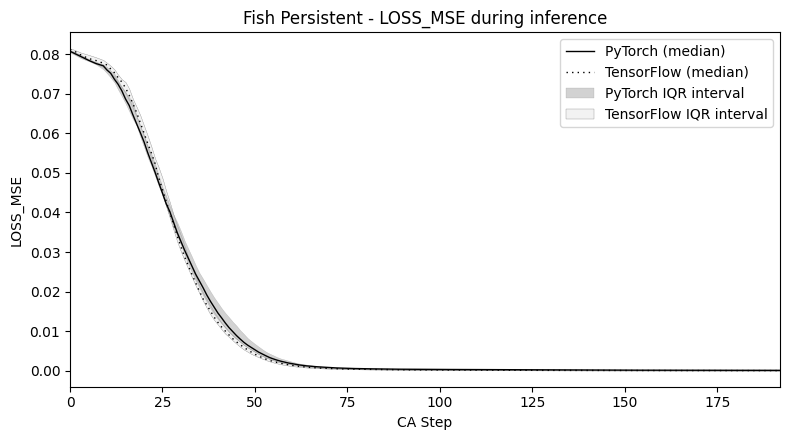

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_persistent (loss_mse):
           avg_abs_gap: 0.000539541487022163
              rmse_gap: 0.0009357519523099505
               max_gap: 0.002844352275133133
       step_at_max_gap: 17.0
      relative_gap_pct: 41.45048539349994
      avg_abs_gap_tail: 7.28865625660072e-05
     avg_abs_gap_64_96: 0.0001749123438264924
  iqr_overlap_fraction: 0.29015544041450775
        t_to_thresh_pt: 44
      t_to_thresh_gnca: 43
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.0006181779308737983
       gnca_mean_64_96: 0.00044326558704730604
          pt_mean_tail: 0.000137051076853775
        gnca_mean_tail: 6.416451428776781e-05


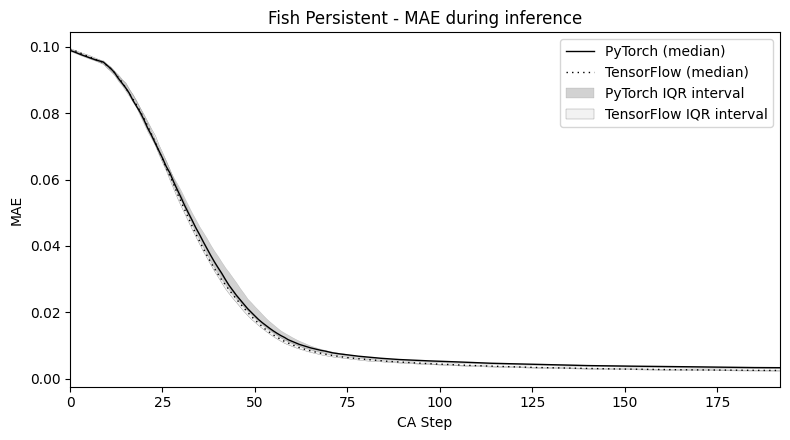

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_persistent (mae):
           avg_abs_gap: 0.0008821031445525804
              rmse_gap: 0.0009543237034131816
               max_gap: 0.0021120607852936
       step_at_max_gap: 37.0
      relative_gap_pct: 15.881072376992082
      avg_abs_gap_tail: 0.0008596062514698201
     avg_abs_gap_64_96: 0.0008110748533385258
  iqr_overlap_fraction: 0.32642487046632124
        t_to_thresh_pt: 64
      t_to_thresh_gnca: 61
     delta_t_to_thresh: 3
         pt_mean_64_96: 0.006910467209915268
       gnca_mean_64_96: 0.0060993923565767424
          pt_mean_tail: 0.003428876888938205
        gnca_mean_tail: 0.002569270637468385


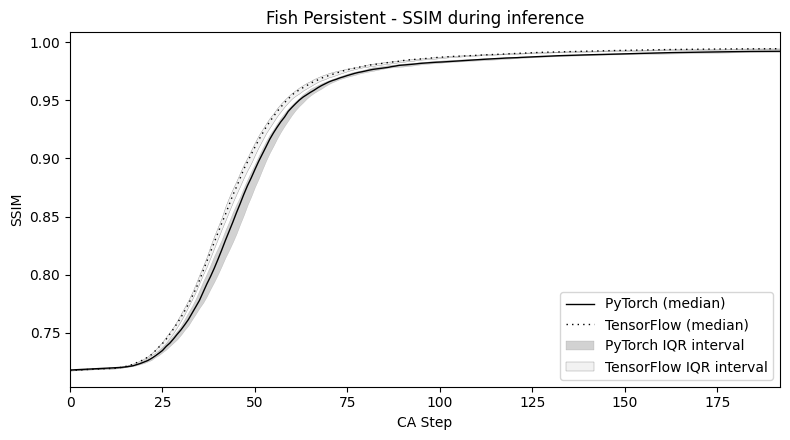

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_persistent (ssim):
           avg_abs_gap: 0.005710685996093743
              rmse_gap: 0.008096137507392836
               max_gap: 0.02325057999999991
       step_at_max_gap: 44.0
      relative_gap_pct: 0.6341094476104304
      avg_abs_gap_tail: 0.002305454999999984
     avg_abs_gap_64_96: 0.004841986363636349
  iqr_overlap_fraction: 0.05181347150259067
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9730375081818181
       gnca_mean_64_96: 0.9778794945454545
          pt_mean_tail: 0.9920042677499998
        gnca_mean_tail: 0.99430972275


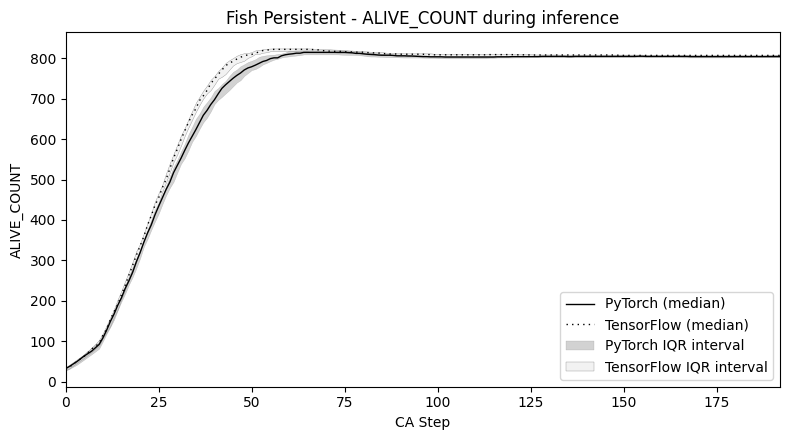

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_persistent (alive_count):
           avg_abs_gap: 10.578776041666666
              rmse_gap: 17.446742808771404
               max_gap: 54.0
       step_at_max_gap: 36.0
      relative_gap_pct: 1.8271294265626392
      avg_abs_gap_tail: 3.0
     avg_abs_gap_64_96: 4.212121212121212
  iqr_overlap_fraction: 0.45595854922279794
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 810.4545454545455
       gnca_mean_64_96: 814.6666666666666
          pt_mean_tail: 804.0
        gnca_mean_tail: 807.0


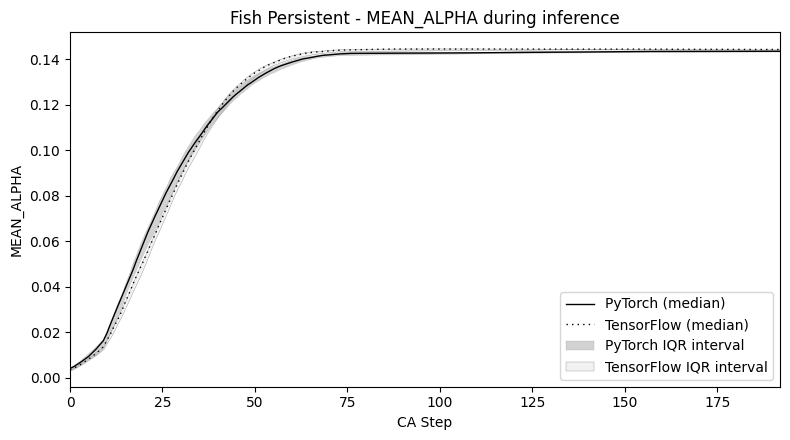

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_persistent (mean_alpha):
           avg_abs_gap: 0.002103935232601847
              rmse_gap: 0.0027147895631907475
               max_gap: 0.008336162194609656
       step_at_max_gap: 21.0
      relative_gap_pct: 3.2471131871757812
      avg_abs_gap_tail: 0.0008454635739326532
     avg_abs_gap_64_96: 0.0017664820858926409
  iqr_overlap_fraction: 0.18134715025906736
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.1423860176494627
       gnca_mean_64_96: 0.14415249973535532
          pt_mean_tail: 0.14354805406183
        gnca_mean_tail: 0.14439351763576266

Analyzing: fish_regenerating


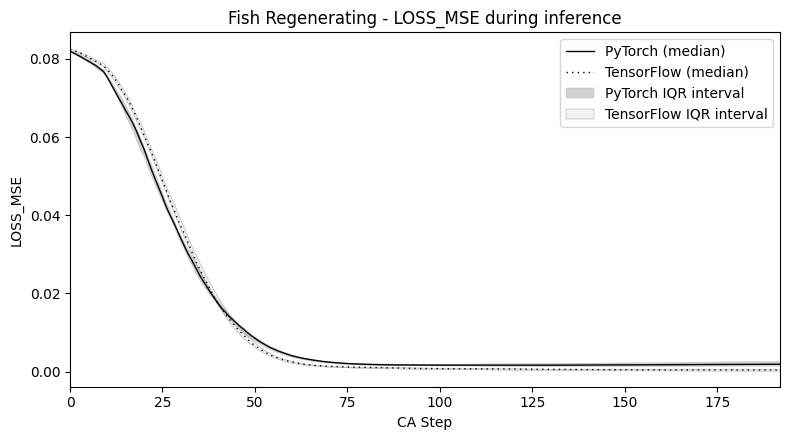

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_regenerating (loss_mse):
           avg_abs_gap: 0.001447951829675273
              rmse_gap: 0.0016824231763749083
               max_gap: 0.004495618864893899
       step_at_max_gap: 22.0
      relative_gap_pct: 67.35579767104028
      avg_abs_gap_tail: 0.00146045416186098
     avg_abs_gap_64_96: 0.0009162052336967302
  iqr_overlap_fraction: 0.07253886010362694
        t_to_thresh_pt: 48
      t_to_thresh_gnca: 47
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.002062822108255702
       gnca_mean_64_96: 0.0011466168745589713
          pt_mean_tail: 0.0018678631953661803
        gnca_mean_tail: 0.0004074090335052


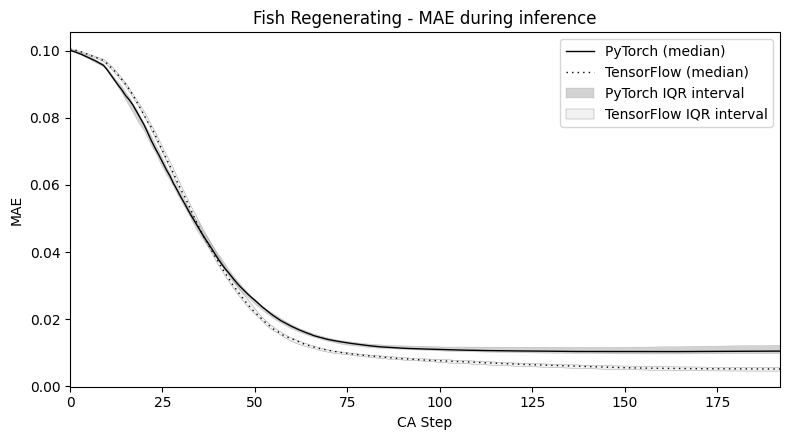

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_regenerating (mae):
           avg_abs_gap: 0.003577478724158329
              rmse_gap: 0.0037946618741670074
               max_gap: 0.005341677227988824
       step_at_max_gap: 192.0
      relative_gap_pct: 34.681904506082546
      avg_abs_gap_tail: 0.00526077989488841
     avg_abs_gap_64_96: 0.0031712284932533916
  iqr_overlap_fraction: 0.07253886010362694
        t_to_thresh_pt: nan
      t_to_thresh_gnca: 74
     delta_t_to_thresh: nan
         pt_mean_64_96: 0.012671454837827924
       gnca_mean_64_96: 0.009500226344574533
          pt_mean_tail: 0.01048510826658453
        gnca_mean_tail: 0.00522432837169612


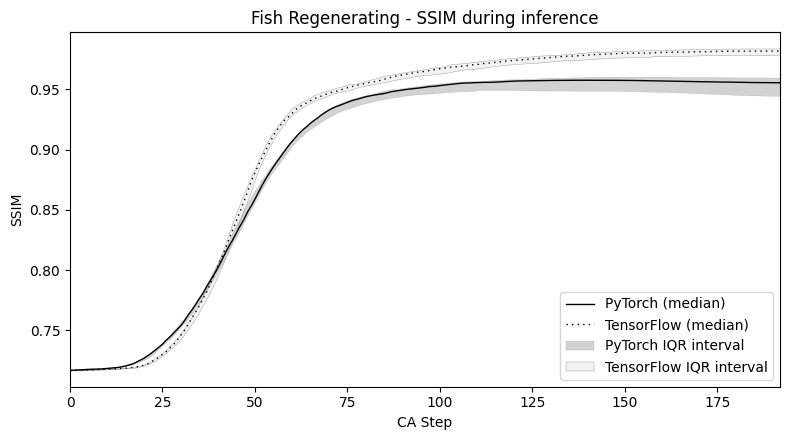

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_regenerating (ssim):
           avg_abs_gap: 0.01568101837890625
              rmse_gap: 0.017571032092384496
               max_gap: 0.02632971500000003
       step_at_max_gap: 192.0
      relative_gap_pct: 1.6708873883874111
      avg_abs_gap_tail: 0.025849341624999977
     avg_abs_gap_64_96: 0.01315675500000002
  iqr_overlap_fraction: 0.07253886010362694
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9410428153030302
       gnca_mean_64_96: 0.9541995703030304
          pt_mean_tail: 0.9557983347500001
        gnca_mean_tail: 0.981647676375


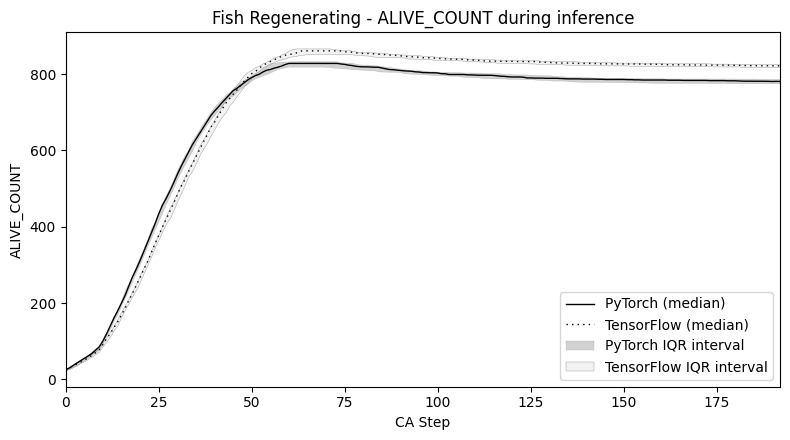

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_regenerating (alive_count):
           avg_abs_gap: 35.147135416666664
              rmse_gap: 37.18230005661296
               max_gap: 57.5
       step_at_max_gap: 26.0
      relative_gap_pct: 5.715870003518707
      avg_abs_gap_tail: 40.7375
     avg_abs_gap_64_96: 35.39393939393939
  iqr_overlap_fraction: 0.10880829015544041
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 818.8939393939394
       gnca_mean_64_96: 854.2878787878788
          pt_mean_tail: 781.9125
        gnca_mean_tail: 822.65


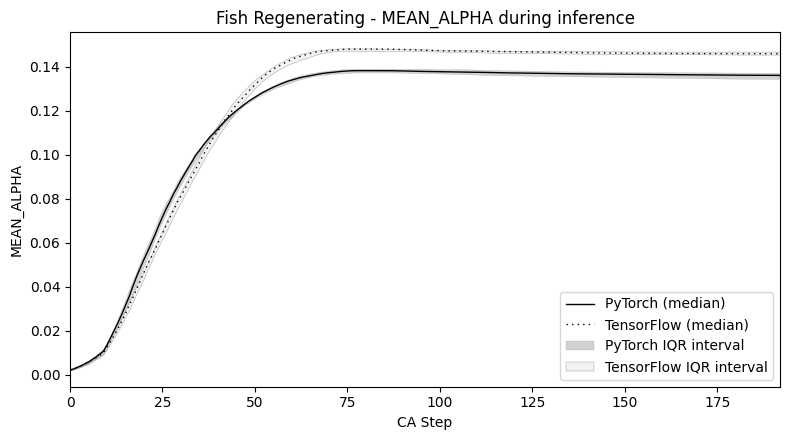

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for fish_regenerating (mean_alpha):
           avg_abs_gap: 0.008041543201898094
              rmse_gap: 0.008565151314117267
               max_gap: 0.010249860584735898
       step_at_max_gap: 67.0
      relative_gap_pct: 6.714251061533891
      avg_abs_gap_tail: 0.00977836810052395
     avg_abs_gap_64_96: 0.00986882299184799
  iqr_overlap_fraction: 0.12953367875647667
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.13769403664451652
       gnca_mean_64_96: 0.1475628596363645
          pt_mean_tail: 0.1361091777682304
        gnca_mean_tail: 0.14588754586875435

Analyzing: ladybug_growing


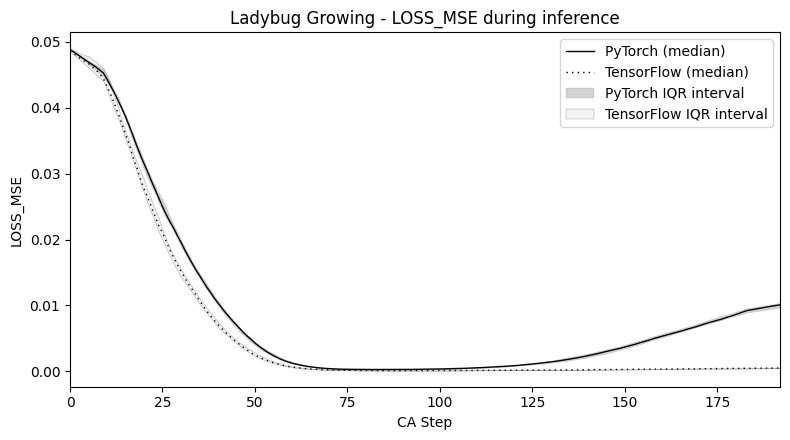

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_growing (loss_mse):
           avg_abs_gap: 0.0025869910144820114
              rmse_gap: 0.0036914984421019376
               max_gap: 0.009589048204361475
       step_at_max_gap: 192.0
      relative_gap_pct: 101.38930626408211
      avg_abs_gap_tail: 0.00846826471643001
     avg_abs_gap_64_96: 0.00018805436499833939
  iqr_overlap_fraction: 0.06217616580310881
        t_to_thresh_pt: 41
      t_to_thresh_gnca: 36
     delta_t_to_thresh: 5
         pt_mean_64_96: 0.0003405999349055803
       gnca_mean_64_96: 0.00015254556990724092
          pt_mean_tail: 0.008912215055897798
        gnca_mean_tail: 0.00044395033946778995


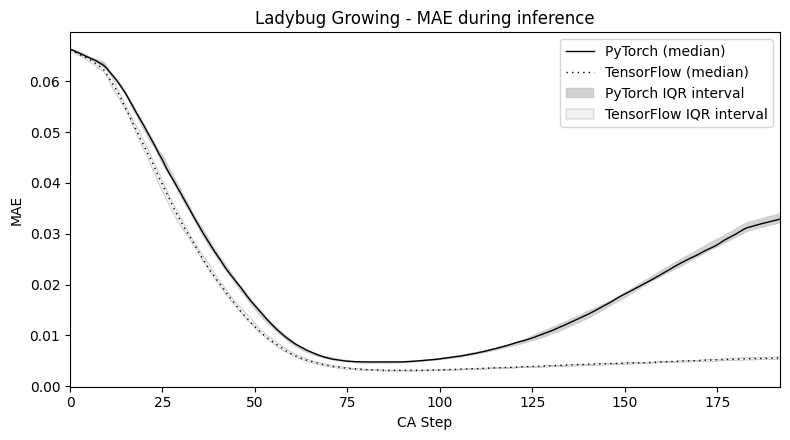

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_growing (mae):
           avg_abs_gap: 0.007735489046050744
              rmse_gap: 0.010977581751165928
               max_gap: 0.027318696957081553
       step_at_max_gap: 192.0
      relative_gap_pct: 63.92808755906971
      avg_abs_gap_tail: 0.025104780046967784
     avg_abs_gap_64_96: 0.00160555747887967
  iqr_overlap_fraction: 0.05699481865284974
        t_to_thresh_pt: 58
      t_to_thresh_gnca: 53
     delta_t_to_thresh: 5
         pt_mean_64_96: 0.005186955642067982
       gnca_mean_64_96: 0.0035813981631883118
          pt_mean_tail: 0.03048932733945543
        gnca_mean_tail: 0.005384547292487648


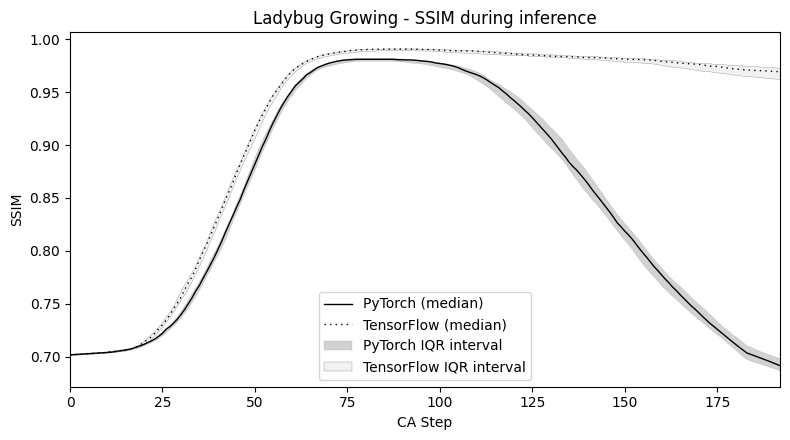

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_growing (ssim):
           avg_abs_gap: 0.07558523287760417
              rmse_gap: 0.11809645135765012
               max_gap: 0.27741213249999996
       step_at_max_gap: 192.0
      relative_gap_pct: 8.675994477730994
      avg_abs_gap_tail: 0.26301029875000004
     avg_abs_gap_64_96: 0.009683142575757609
  iqr_overlap_fraction: 0.10880829015544041
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9786278954545455
       gnca_mean_64_96: 0.9883110380303028
          pt_mean_tail: 0.7084409513749998
        gnca_mean_tail: 0.9714512501249997


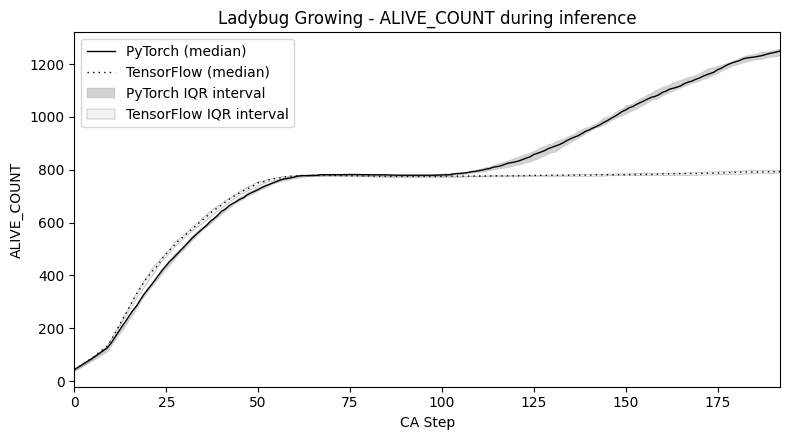

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_growing (alive_count):
           avg_abs_gap: 112.68098958333333
              rmse_gap: 183.80574285579556
               max_gap: 457.0
       step_at_max_gap: 192.0
      relative_gap_pct: 13.03901395839053
      avg_abs_gap_tail: 423.85
     avg_abs_gap_64_96: 4.015151515151516
  iqr_overlap_fraction: 0.18134715025906736
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 780.5757575757576
       gnca_mean_64_96: 776.5909090909091
          pt_mean_tail: 1214.5125
        gnca_mean_tail: 790.6625


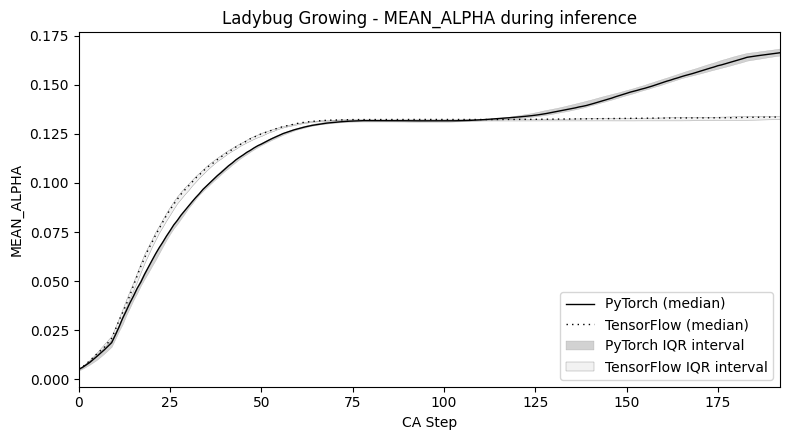


Metrics for ladybug_growing (mean_alpha):
           avg_abs_gap: 0.008282722107045023
              rmse_gap: 0.012452650737553203
               max_gap: 0.032710764557123156
       step_at_max_gap: 192.0
      relative_gap_pct: 7.107503966359283
      avg_abs_gap_tail: 0.029703668691217894
     avg_abs_gap_64_96: 0.0008699223399162317
  iqr_overlap_fraction: 0.19689119170984457
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.13131412321870972
       gnca_mean_64_96: 0.13218404555862595
          pt_mean_tail: 0.16307652331888672
        gnca_mean_tail: 0.13337285462766882

Analyzing: ladybug_persistent


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


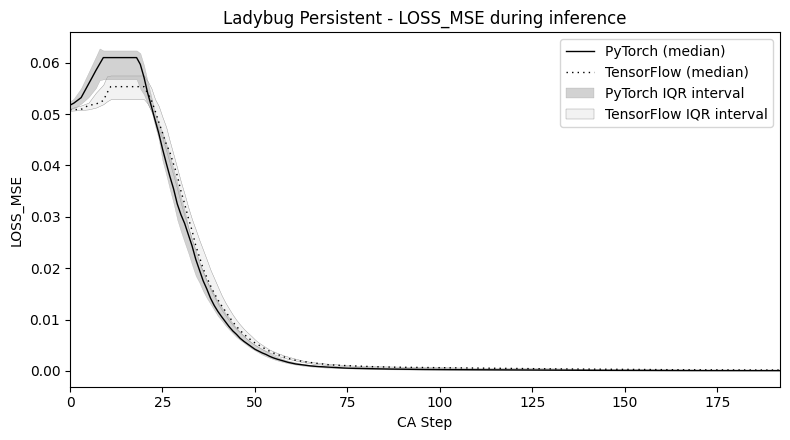

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_persistent (loss_mse):
           avg_abs_gap: 0.0011529978619293387
              rmse_gap: 0.0020613115322621234
               max_gap: 0.008380362764000907
       step_at_max_gap: 9.0
      relative_gap_pct: 64.92463646773547
      avg_abs_gap_tail: 0.00011630822937145136
     avg_abs_gap_64_96: 0.00044778388506860455
  iqr_overlap_fraction: 0.20207253886010362
        t_to_thresh_pt: 42
      t_to_thresh_gnca: 44
     delta_t_to_thresh: -2
         pt_mean_64_96: 0.0005108030441491758
       gnca_mean_64_96: 0.0009585869292177803
          pt_mean_tail: 6.00653898800374e-05
        gnca_mean_tail: 0.00017637361925148875


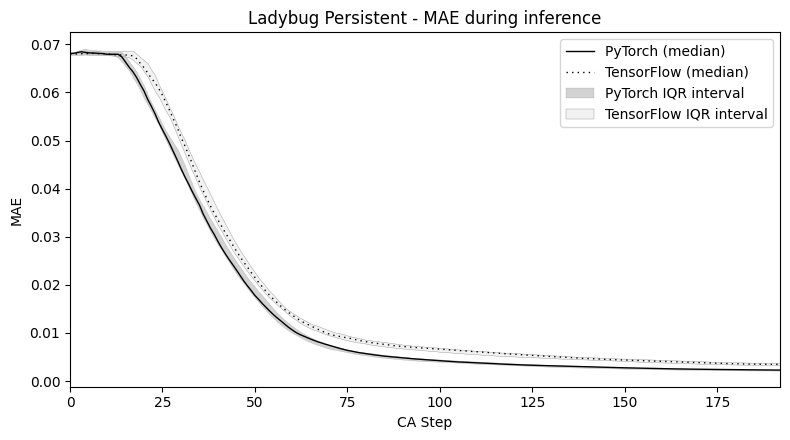

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_persistent (mae):
           avg_abs_gap: 0.002449984296769498
              rmse_gap: 0.0028782525877793243
               max_gap: 0.007175913080573103
       step_at_max_gap: 25.0
      relative_gap_pct: 32.0824820772287
      avg_abs_gap_tail: 0.001223788323113695
     avg_abs_gap_64_96: 0.002473844695046096
  iqr_overlap_fraction: 0.07772020725388601
        t_to_thresh_pt: 62
      t_to_thresh_gnca: 70
     delta_t_to_thresh: -8
         pt_mean_64_96: 0.006080075703335479
       gnca_mean_64_96: 0.008553920398381576
          pt_mean_tail: 0.0023519427428254354
        gnca_mean_tail: 0.00357573106593913


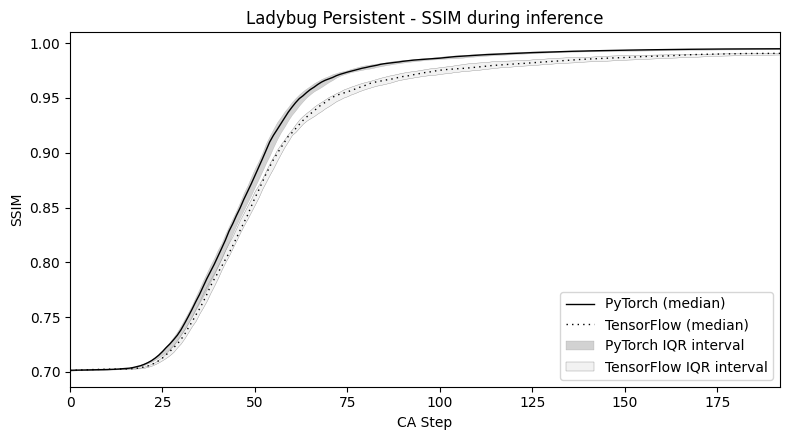

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_persistent (ssim):
           avg_abs_gap: 0.01010639854166667
              rmse_gap: 0.012004061377592084
               max_gap: 0.023710520000000068
       step_at_max_gap: 62.0
      relative_gap_pct: 1.0896549518831122
      avg_abs_gap_tail: 0.004346143875000025
     avg_abs_gap_64_96: 0.016617390303030315
  iqr_overlap_fraction: 0.11917098445595854
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.975394576969697
       gnca_mean_64_96: 0.9587771866666667
          pt_mean_tail: 0.994678852625
        gnca_mean_tail: 0.9903327087500001


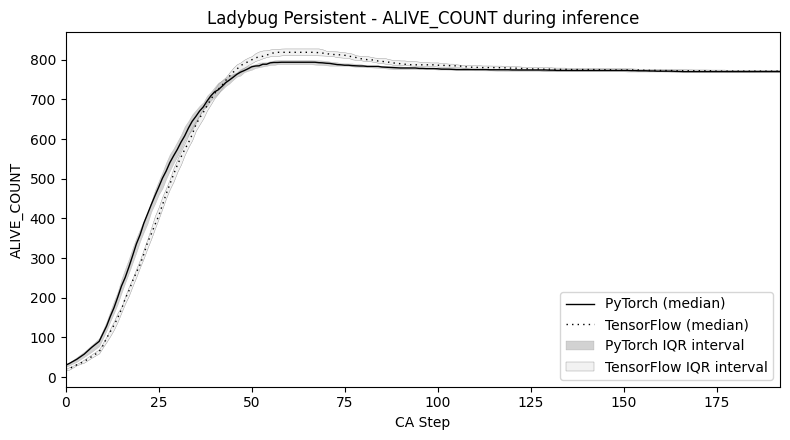

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_persistent (alive_count):
           avg_abs_gap: 15.179036458333334
              rmse_gap: 23.58679188236678
               max_gap: 78.0
       step_at_max_gap: 21.0
      relative_gap_pct: 5.351705548284892
      avg_abs_gap_tail: 1.1
     avg_abs_gap_64_96: 17.863636363636363
  iqr_overlap_fraction: 0.5181347150259067
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 784.8030303030303
       gnca_mean_64_96: 802.6666666666666
          pt_mean_tail: 770.0
        gnca_mean_tail: 771.1


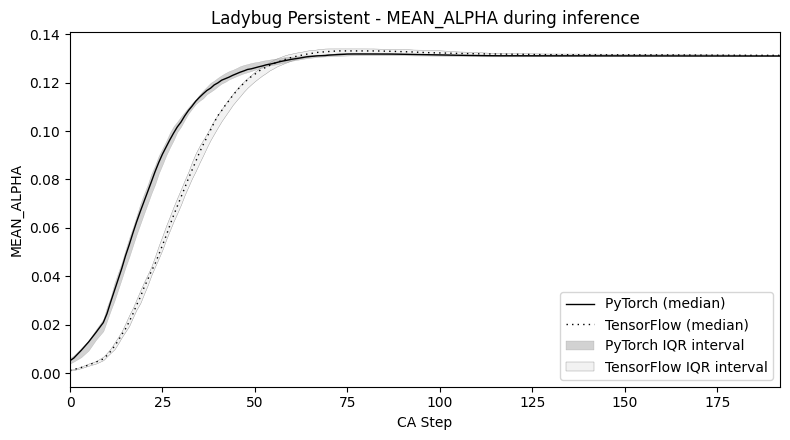

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_persistent (mean_alpha):
           avg_abs_gap: 0.005973101836768059
              rmse_gap: 0.012246290745829322
               max_gap: 0.038075953722000094
       step_at_max_gap: 24.0
      relative_gap_pct: 15.525589103862439
      avg_abs_gap_tail: 0.00029994025826453883
     avg_abs_gap_64_96: 0.0012407573786648888
  iqr_overlap_fraction: 0.40414507772020725
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.13154302988991592
       gnca_mean_64_96: 0.1327837872685808
          pt_mean_tail: 0.13096533864736554
        gnca_mean_tail: 0.13126527890563006

Analyzing: ladybug_regenerating


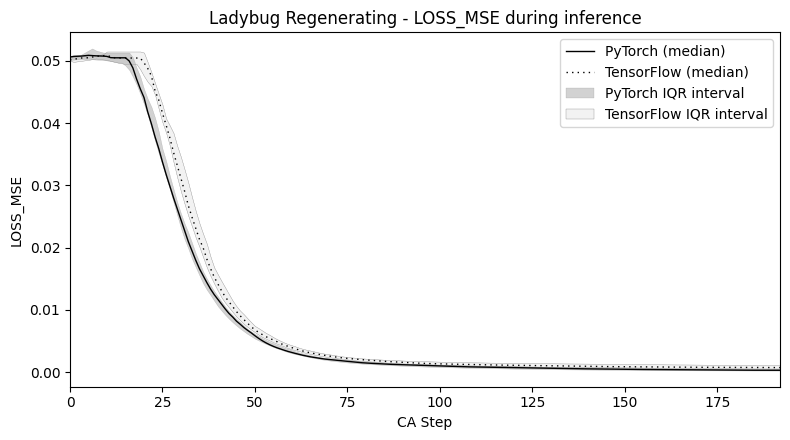

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_regenerating (loss_mse):
           avg_abs_gap: 0.0011337478396361187
              rmse_gap: 0.002157901923354029
               max_gap: 0.007907832041382797
       step_at_max_gap: 26.0
      relative_gap_pct: 38.289505420436534
      avg_abs_gap_tail: 0.00043442762507763254
     avg_abs_gap_64_96: 0.0004756399836024303
  iqr_overlap_fraction: 0.09326424870466321
        t_to_thresh_pt: 43
      t_to_thresh_gnca: 45
     delta_t_to_thresh: -2
         pt_mean_64_96: 0.00158980621772842
       gnca_mean_64_96: 0.0020654462013308494
          pt_mean_tail: 0.0003096103831921525
        gnca_mean_tail: 0.0007440380082697851


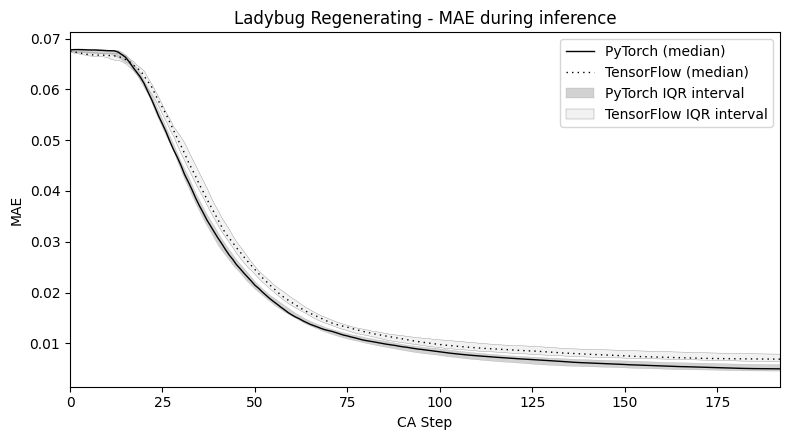

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_regenerating (mae):
           avg_abs_gap: 0.0019343404749937079
              rmse_gap: 0.002094384908398431
               max_gap: 0.004269946366548545
       step_at_max_gap: 34.0
      relative_gap_pct: 17.252605132465092
      avg_abs_gap_tail: 0.0018635419255588225
     avg_abs_gap_64_96: 0.0016876649337284424
  iqr_overlap_fraction: 0.11398963730569948
        t_to_thresh_pt: 85
      t_to_thresh_gnca: 98
     delta_t_to_thresh: -13
         pt_mean_64_96: 0.010858325696917148
       gnca_mean_64_96: 0.01254599063064559
          pt_mean_tail: 0.005067407299065915
        gnca_mean_tail: 0.006930949224624737


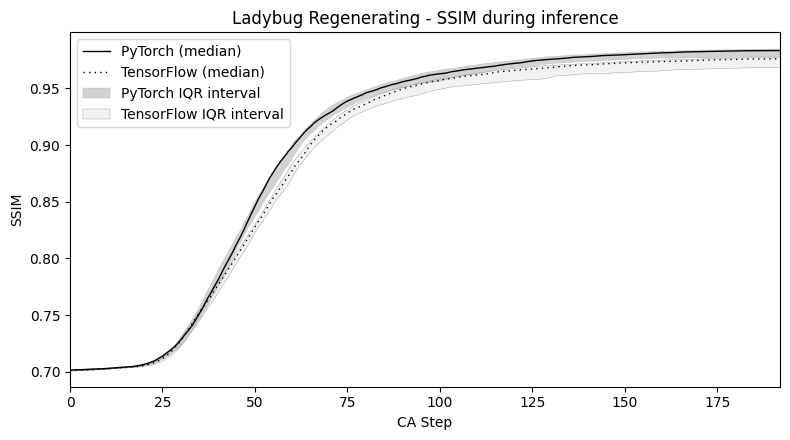

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_regenerating (ssim):
           avg_abs_gap: 0.007359060097656245
              rmse_gap: 0.008974520242899336
               max_gap: 0.02331890000000003
       step_at_max_gap: 56.0
      relative_gap_pct: 0.7977330368733042
      avg_abs_gap_tail: 0.007386281874999995
     avg_abs_gap_64_96: 0.009472406818181817
  iqr_overlap_fraction: 0.29533678756476683
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9425326243939393
       gnca_mean_64_96: 0.9330602175757575
          pt_mean_tail: 0.9830405916249999
        gnca_mean_tail: 0.97565430975


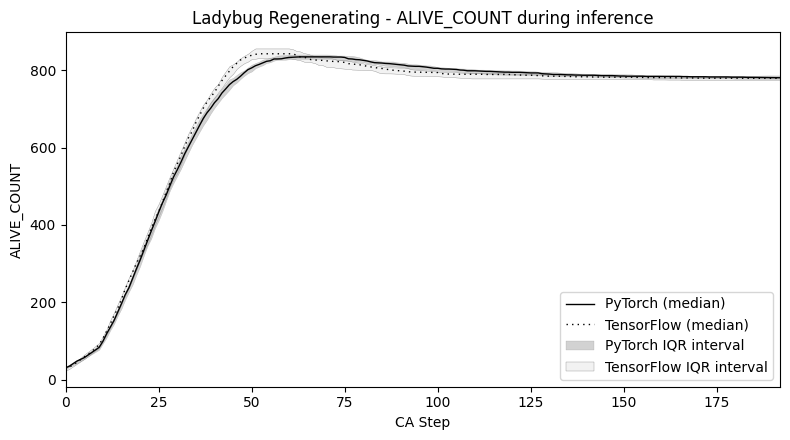

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_regenerating (alive_count):
           avg_abs_gap: 10.030598958333334
              rmse_gap: 13.324873211169779
               max_gap: 42.0
       step_at_max_gap: 47.0
      relative_gap_pct: 1.8810229221278854
      avg_abs_gap_tail: 2.3875
     avg_abs_gap_64_96: 12.303030303030303
  iqr_overlap_fraction: 0.7564766839378239
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 824.0909090909091
       gnca_mean_64_96: 811.7878787878788
          pt_mean_tail: 781.675
        gnca_mean_tail: 779.2875


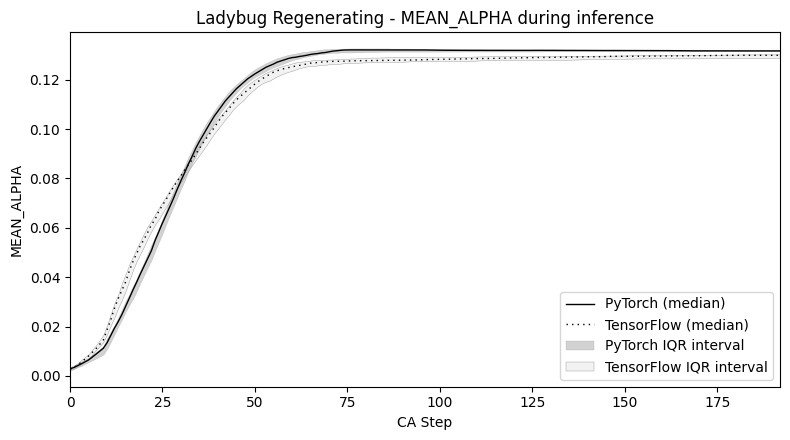

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for ladybug_regenerating (mean_alpha):
           avg_abs_gap: 0.003575643091456495
              rmse_gap: 0.004147265066710258
               max_gap: 0.011542314663529403
       step_at_max_gap: 18.0
      relative_gap_pct: 5.183793512254437
      avg_abs_gap_tail: 0.001791116967797267
     avg_abs_gap_64_96: 0.004122176856705642
  iqr_overlap_fraction: 0.08808290155440414
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.13176033916798502
       gnca_mean_64_96: 0.12763816231127936
          pt_mean_tail: 0.13170192893594498
        gnca_mean_tail: 0.12991081196814772

Analyzing: lizard_growing


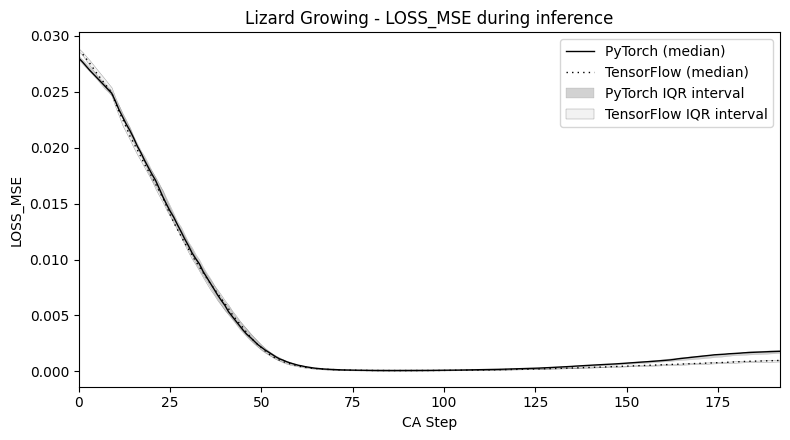

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_growing (loss_mse):
           avg_abs_gap: 0.000232774563850548
              rmse_gap: 0.0003393322509236024
               max_gap: 0.000815528692328375
       step_at_max_gap: 192.0
      relative_gap_pct: 23.15580182227915
      avg_abs_gap_tail: 0.0007724110269919039
     avg_abs_gap_64_96: 1.1153870273666521e-05
  iqr_overlap_fraction: 0.45595854922279794
        t_to_thresh_pt: 33
      t_to_thresh_gnca: 32
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.00012817680941553595
       gnca_mean_64_96: 0.00011702293914186945
          pt_mean_tail: 0.0016528487278264451
        gnca_mean_tail: 0.0008804377008345413


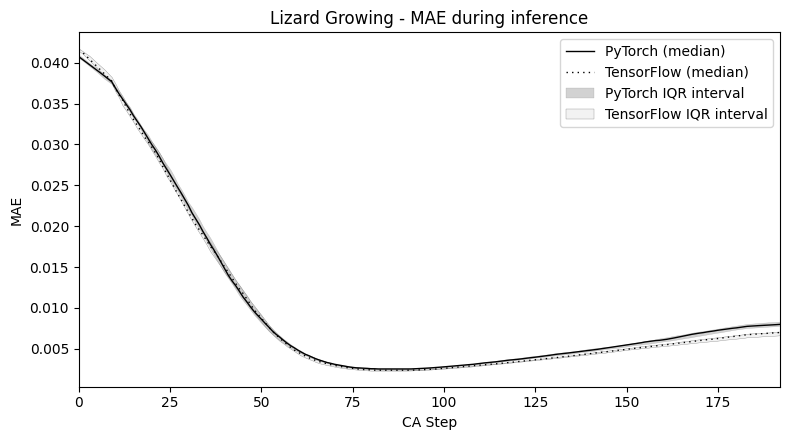

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_growing (mae):
           avg_abs_gap: 0.00042481956188567216
              rmse_gap: 0.0005150065914358531
               max_gap: 0.0010287088807672002
       step_at_max_gap: 178.0
      relative_gap_pct: 6.8654397548815735
      avg_abs_gap_tail: 0.001008907915093008
     avg_abs_gap_64_96: 0.0001598956225665592
  iqr_overlap_fraction: 0.38860103626943004
        t_to_thresh_pt: 48
      t_to_thresh_gnca: 48
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.0028015014567327246
       gnca_mean_64_96: 0.0026416058341661654
          pt_mean_tail: 0.007633907691342709
        gnca_mean_tail: 0.006624999776249701


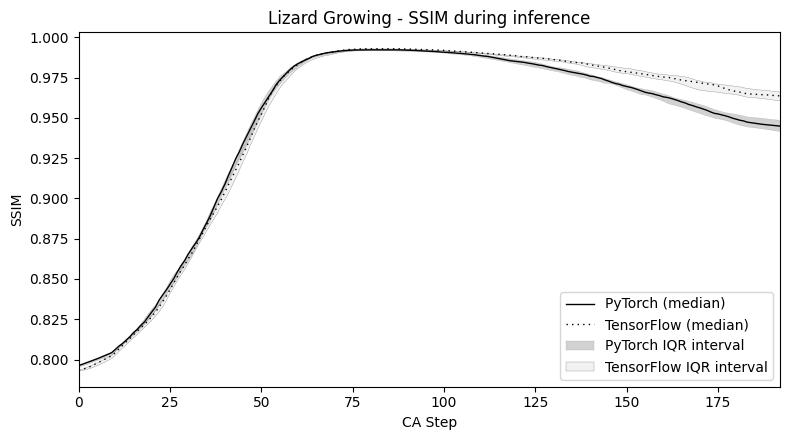

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_growing (ssim):
           avg_abs_gap: 0.005448331699218746
              rmse_gap: 0.007850290503160577
               max_gap: 0.018797375000000116
       step_at_max_gap: 192.0
      relative_gap_pct: 0.575907824750086
      avg_abs_gap_tail: 0.01774064125
     avg_abs_gap_64_96: 0.0005230898484848314
  iqr_overlap_fraction: 0.3471502590673575
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9914988869696969
       gnca_mean_64_96: 0.9920071798484849
          pt_mean_tail: 0.9484274261249999
        gnca_mean_tail: 0.9661680673749998


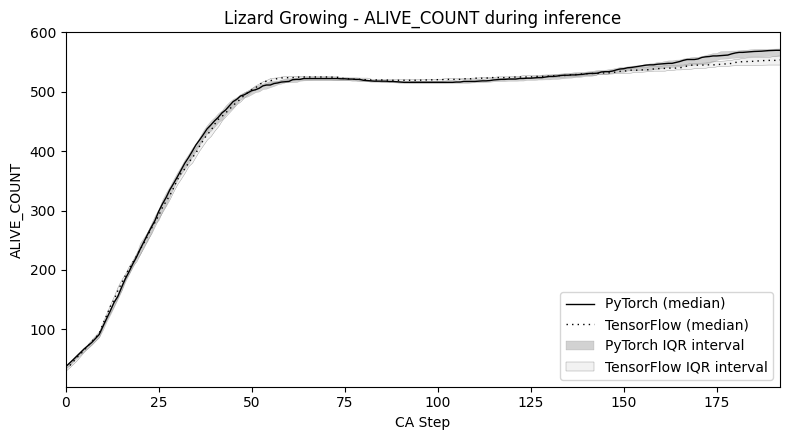


Metrics for lizard_growing (alive_count):
           avg_abs_gap: 5.455729166666667
              rmse_gap: 7.091225688894222
               max_gap: 17.0
       step_at_max_gap: 191.0
      relative_gap_pct: 1.4355170385422273
      avg_abs_gap_tail: 15.7875
     avg_abs_gap_64_96: 2.090909090909091
  iqr_overlap_fraction: 0.7772020725388601
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 519.6212121212121
       gnca_mean_64_96: 521.7121212121212
          pt_mean_tail: 565.75
        gnca_mean_tail: 549.9625


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


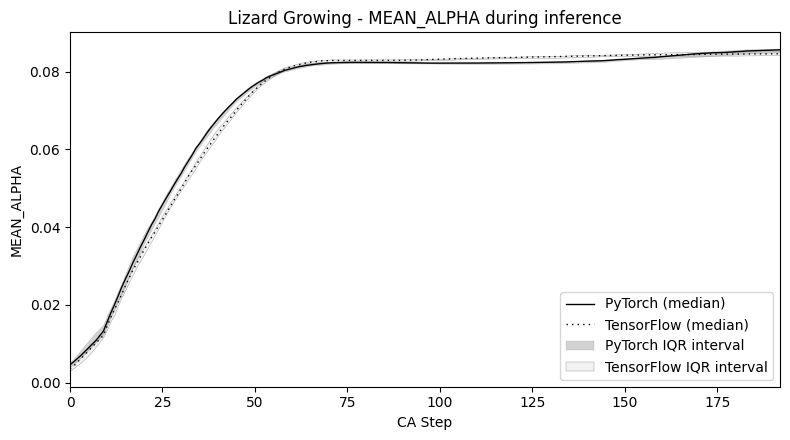

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_growing (mean_alpha):
           avg_abs_gap: 0.0013023786330753292
              rmse_gap: 0.0016818099605164225
               max_gap: 0.004386104643344851
       step_at_max_gap: 34.0
      relative_gap_pct: 2.7665553680237696
      avg_abs_gap_tail: 0.0006766485981643241
     avg_abs_gap_64_96: 0.0006056336516683807
  iqr_overlap_fraction: 0.33678756476683935
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08221589536829423
       gnca_mean_64_96: 0.08282152901996262
          pt_mean_tail: 0.08519584527239199
        gnca_mean_tail: 0.08451919667422766

Analyzing: lizard_persistent


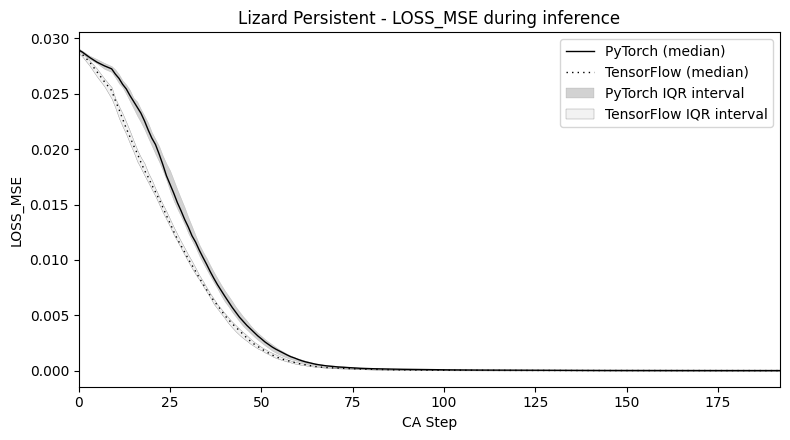

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_persistent (loss_mse):
           avg_abs_gap: 0.0006754175930758721
              rmse_gap: 0.0013767091228545911
               max_gap: 0.004462889395654198
       step_at_max_gap: 18.0
      relative_gap_pct: 35.99467207387905
      avg_abs_gap_tail: 3.9091822600312295e-06
     avg_abs_gap_64_96: 8.454433246337075e-05
  iqr_overlap_fraction: 0.19170984455958548
        t_to_thresh_pt: 35
      t_to_thresh_gnca: 31
     delta_t_to_thresh: 4
         pt_mean_64_96: 0.0002444862372860537
       gnca_mean_64_96: 0.00015994190482268293
          pt_mean_tail: 1.5270051221705216e-05
        gnca_mean_tail: 1.1360868961673987e-05


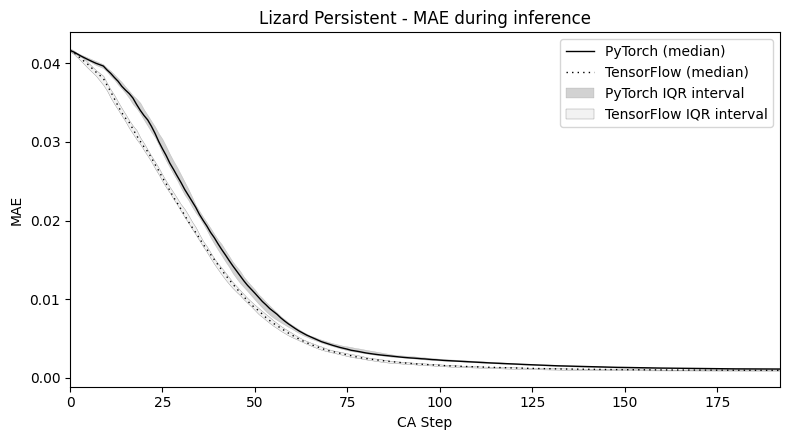

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_persistent (mae):
           avg_abs_gap: 0.0010887544511509412
              rmse_gap: 0.0015622802690428306
               max_gap: 0.004025068134069443
       step_at_max_gap: 21.0
      relative_gap_pct: 21.592300316349917
      avg_abs_gap_tail: 0.00018144750938517377
     avg_abs_gap_64_96: 0.0007545363941145242
  iqr_overlap_fraction: 0.02072538860103627
        t_to_thresh_pt: 52
      t_to_thresh_gnca: 48
     delta_t_to_thresh: 4
         pt_mean_64_96: 0.0034462174675850225
       gnca_mean_64_96: 0.002691681073470499
          pt_mean_tail: 0.0011561459512449226
        gnca_mean_tail: 0.0009746984418597488


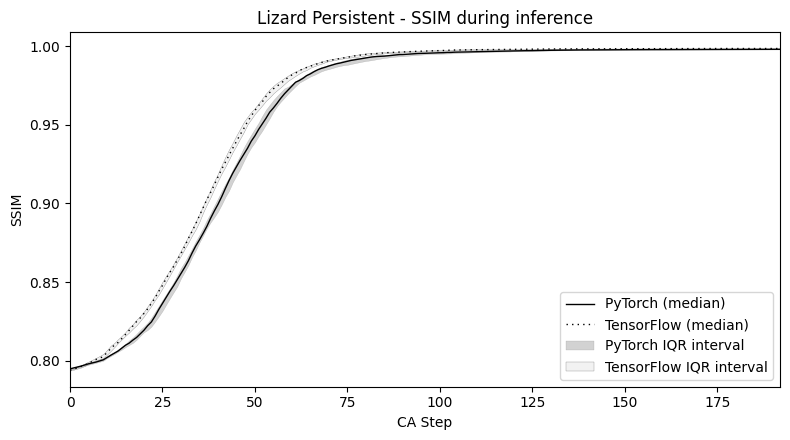

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_persistent (ssim):
           avg_abs_gap: 0.0042418183919270885
              rmse_gap: 0.006804237006570415
               max_gap: 0.01748042999999999
       step_at_max_gap: 41.0
      relative_gap_pct: 0.46306011925751683
      avg_abs_gap_tail: 0.0005406915000000401
     avg_abs_gap_64_96: 0.0025147325757575506
  iqr_overlap_fraction: 0.03626943005181347
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9910852031818183
       gnca_mean_64_96: 0.9935999357575759
          pt_mean_tail: 0.9979181508750001
        gnca_mean_tail: 0.998458842375


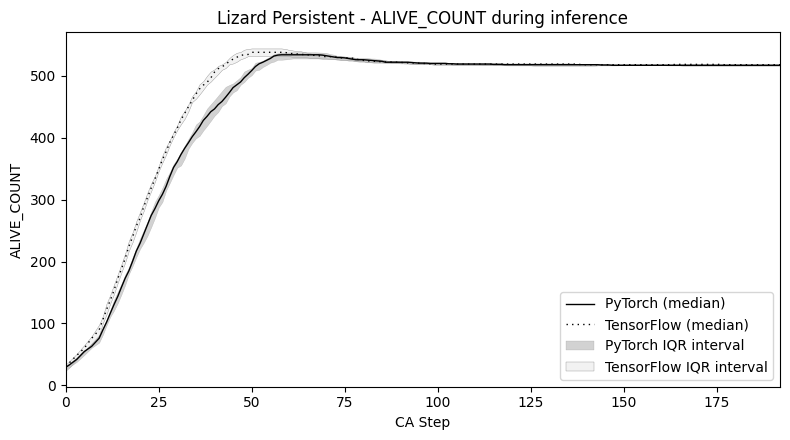

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_persistent (alive_count):
           avg_abs_gap: 11.190755208333334
              rmse_gap: 22.033994362168727
               max_gap: 61.0
       step_at_max_gap: 35.0
      relative_gap_pct: 3.8064684162215463
      avg_abs_gap_tail: 1.1
     avg_abs_gap_64_96: 0.7272727272727273
  iqr_overlap_fraction: 0.5077720207253886
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 526.6363636363636
       gnca_mean_64_96: 526.3030303030303
          pt_mean_tail: 517.0
        gnca_mean_tail: 518.1


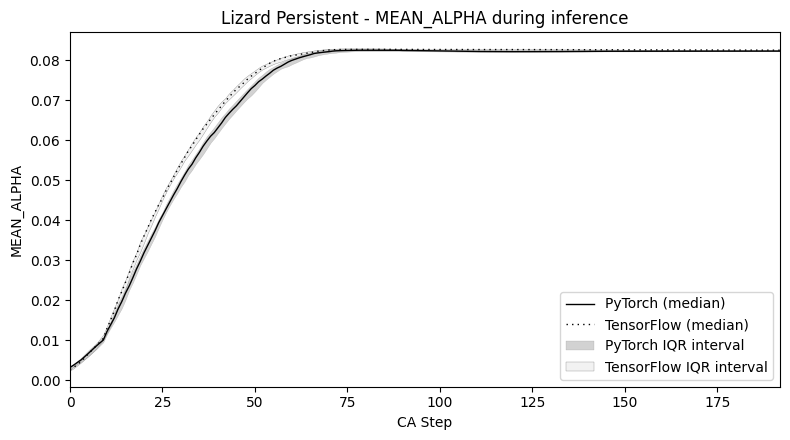

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_persistent (mean_alpha):
           avg_abs_gap: 0.0011956201298441295
              rmse_gap: 0.0019181852708874693
               max_gap: 0.004636192694306346
       step_at_max_gap: 23.0
      relative_gap_pct: 2.6539387524444713
      avg_abs_gap_tail: 0.0002480566501617397
     avg_abs_gap_64_96: 0.00030043043873528304
  iqr_overlap_fraction: 0.27979274611398963
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08232791304136762
       gnca_mean_64_96: 0.08262834348010292
          pt_mean_tail: 0.08230166966095562
        gnca_mean_tail: 0.08254972631111737

Analyzing: lizard_regenerating


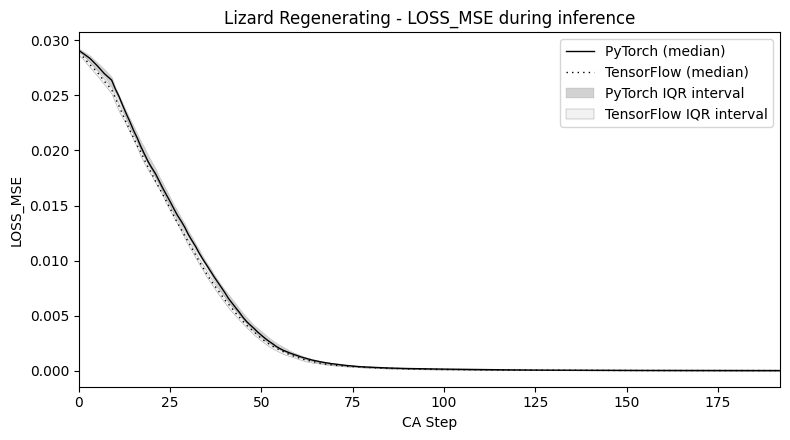

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_regenerating (loss_mse):
           avg_abs_gap: 0.00018877301663877338
              rmse_gap: 0.0003294493417758562
               max_gap: 0.0008741877973079508
       step_at_max_gap: 11.0
      relative_gap_pct: 13.539574349297611
      avg_abs_gap_tail: 6.946673420316074e-06
     avg_abs_gap_64_96: 5.6278924493004556e-05
  iqr_overlap_fraction: 0.5233160621761658
        t_to_thresh_pt: 35
      t_to_thresh_gnca: 33
     delta_t_to_thresh: 2
         pt_mean_64_96: 0.0004202501107955742
       gnca_mean_64_96: 0.0003639711863025697
          pt_mean_tail: 4.286732964828843e-05
        gnca_mean_tail: 3.592065622797236e-05


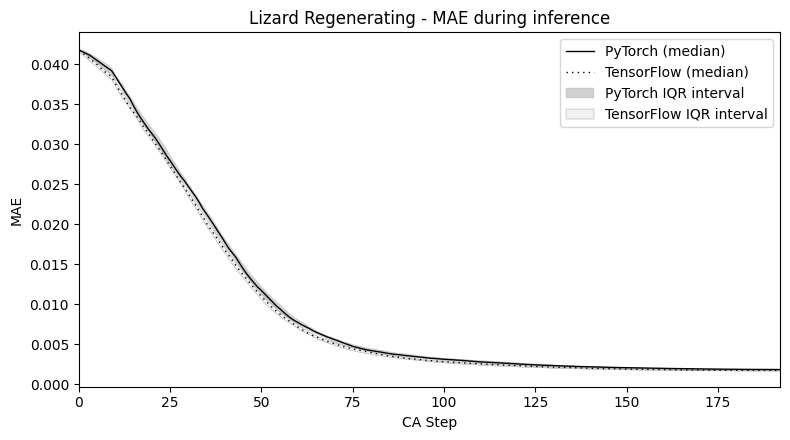

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_regenerating (mae):
           avg_abs_gap: 0.0004056157455731059
              rmse_gap: 0.0004960781922710498
               max_gap: 0.0011787917464971542
       step_at_max_gap: 35.0
      relative_gap_pct: 7.053491432821615
      avg_abs_gap_tail: 0.00012538434530142626
     avg_abs_gap_64_96: 0.0003817873640042226
  iqr_overlap_fraction: 0.12953367875647667
        t_to_thresh_pt: 54
      t_to_thresh_gnca: 53
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.0045449975525225965
       gnca_mean_64_96: 0.004163210188518375
          pt_mean_tail: 0.001893431133066723
        gnca_mean_tail: 0.0017680467877652963


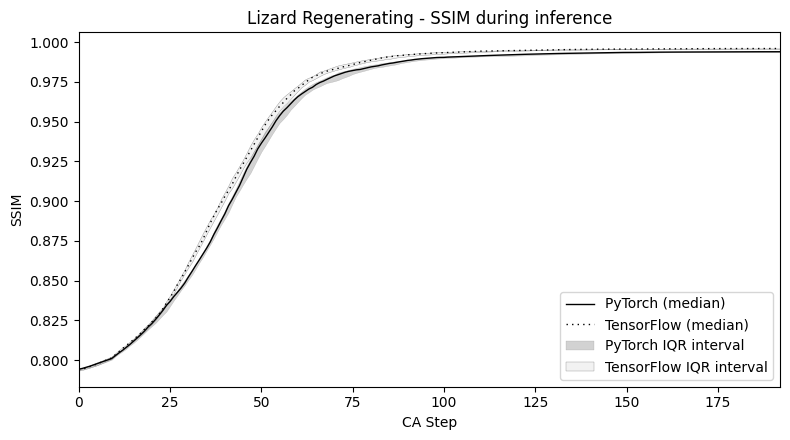

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_regenerating (ssim):
           avg_abs_gap: 0.003525438033854167
              rmse_gap: 0.004347762282412129
               max_gap: 0.011902785000000082
       step_at_max_gap: 36.0
      relative_gap_pct: 0.37095415164536566
      avg_abs_gap_tail: 0.0020363852500000224
     avg_abs_gap_64_96: 0.0041638157575757395
  iqr_overlap_fraction: 0.14507772020725387
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9834300390909091
       gnca_mean_64_96: 0.9875938548484848
          pt_mean_tail: 0.9939206442499999
        gnca_mean_tail: 0.9959570294999999


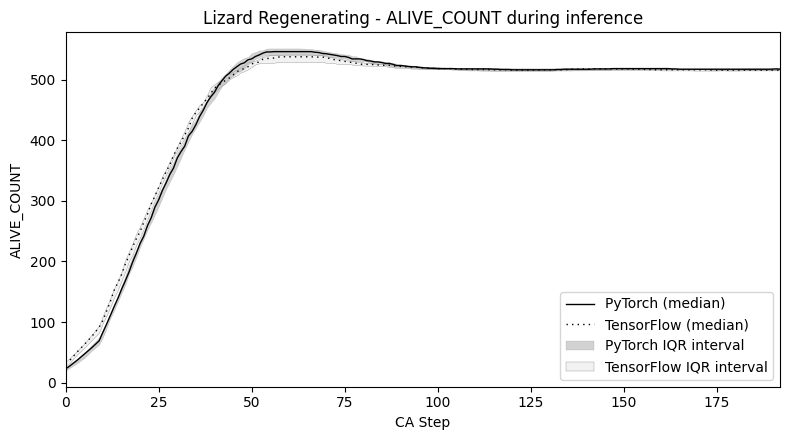

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_regenerating (alive_count):
           avg_abs_gap: 6.173828125
              rmse_gap: 9.650880046766892
               max_gap: 27.5
       step_at_max_gap: 16.0
      relative_gap_pct: 3.332631195726636
      avg_abs_gap_tail: 1.525
     avg_abs_gap_64_96: 5.0606060606060606
  iqr_overlap_fraction: 0.5544041450777202
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 532.6969696969697
       gnca_mean_64_96: 527.6363636363636
          pt_mean_tail: 517.05
        gnca_mean_tail: 515.525


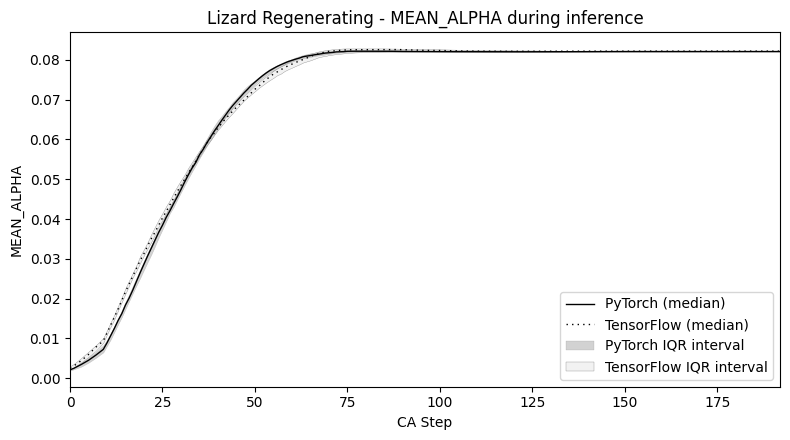

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for lizard_regenerating (mean_alpha):
           avg_abs_gap: 0.0006391891195107715
              rmse_gap: 0.001045293394043192
               max_gap: 0.0035154279321431975
       step_at_max_gap: 16.0
      relative_gap_pct: 2.8936983643347047
      avg_abs_gap_tail: 0.00011710291728375677
     avg_abs_gap_64_96: 0.0003608361338124009
  iqr_overlap_fraction: 0.5854922279792746
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08197314077706043
       gnca_mean_64_96: 0.08228644536751684
          pt_mean_tail: 0.08209712794050572
        gnca_mean_tail: 0.08221423085778948

Analyzing: smiley_growing


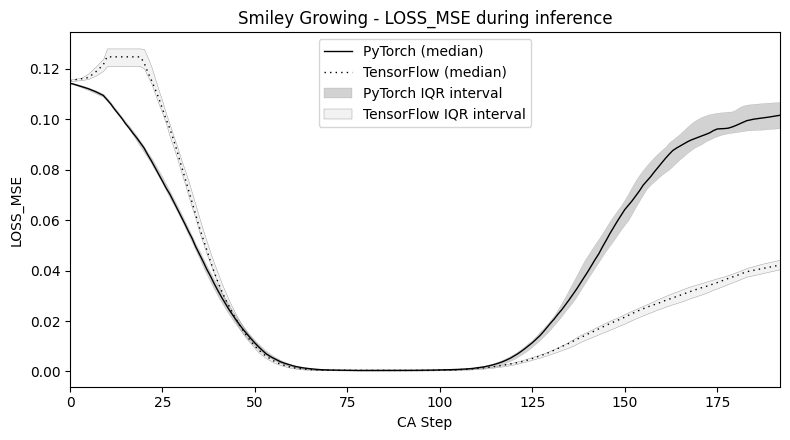

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_growing (loss_mse):
           avg_abs_gap: 0.019412219506042067
              rmse_gap: 0.02977022067232492
               max_gap: 0.06092018075287345
       step_at_max_gap: 175.0
      relative_gap_pct: 45.3848573917997
      avg_abs_gap_tail: 0.059877098770812154
     avg_abs_gap_64_96: 6.912726729007274e-05
  iqr_overlap_fraction: 0.3626943005181347
        t_to_thresh_pt: 51
      t_to_thresh_gnca: 51
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.00053278892345115
       gnca_mean_64_96: 0.0004824415659778469
          pt_mean_tail: 0.09861515490338205
        gnca_mean_tail: 0.03873805613256988


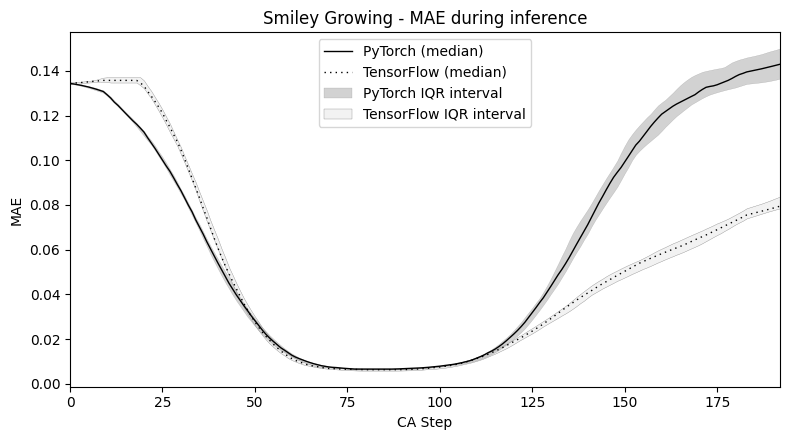

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_growing (mae):
           avg_abs_gap: 0.020342220985185126
              rmse_gap: 0.031874545512255596
               max_gap: 0.06604189425706863
       step_at_max_gap: 172.0
      relative_gap_pct: 26.470876385294712
      avg_abs_gap_tail: 0.06418537897989154
     avg_abs_gap_64_96: 0.00048136737225859706
  iqr_overlap_fraction: 0.32642487046632124
        t_to_thresh_pt: 65
      t_to_thresh_gnca: 62
     delta_t_to_thresh: 3
         pt_mean_64_96: 0.0071965138371468985
       gnca_mean_64_96: 0.006715146464888301
          pt_mean_tail: 0.1383985128253698
        gnca_mean_tail: 0.07421313384547826


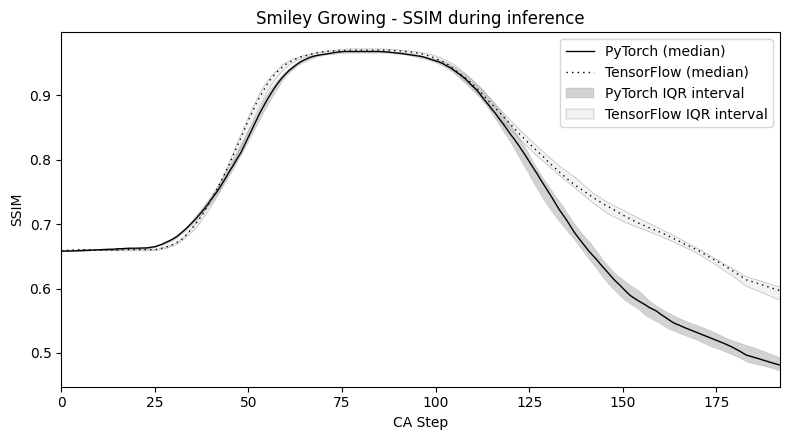

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_growing (ssim):
           avg_abs_gap: 0.04091436664713542
              rmse_gap: 0.06432341183273324
               max_gap: 0.13120655000000003
       step_at_max_gap: 164.0
      relative_gap_pct: 6.4441531877345515
      avg_abs_gap_tail: 0.118632693375
     avg_abs_gap_64_96: 0.003314613939393941
  iqr_overlap_fraction: 0.30569948186528495
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9649463775757575
       gnca_mean_64_96: 0.9682609915151514
          pt_mean_tail: 0.5009262236249999
        gnca_mean_tail: 0.619558917


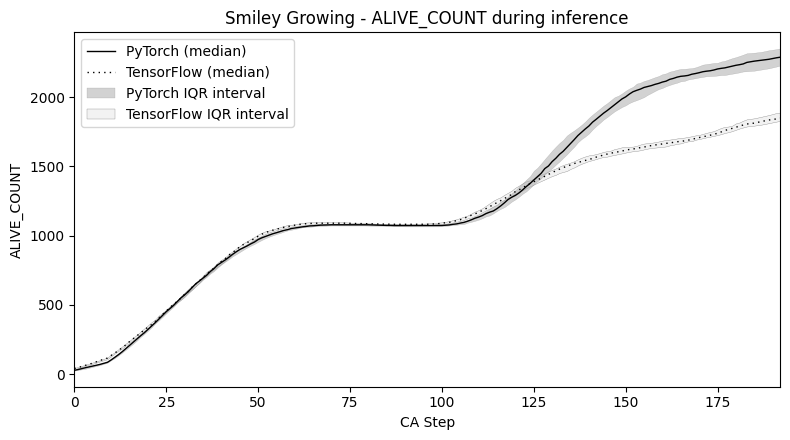

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_growing (alive_count):
           avg_abs_gap: 134.89778645833334
              rmse_gap: 225.72369544688462
               max_gap: 470.5
       step_at_max_gap: 165.0
      relative_gap_pct: 9.906796727591027
      avg_abs_gap_tail: 448.0875
     avg_abs_gap_64_96: 10.424242424242424
  iqr_overlap_fraction: 0.36787564766839376
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 1075.5
       gnca_mean_64_96: 1085.9242424242425
          pt_mean_tail: 2242.7625
        gnca_mean_tail: 1794.675


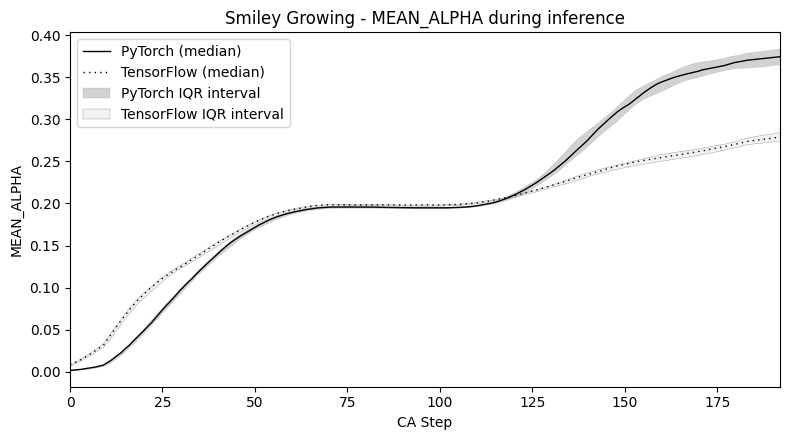

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_growing (mean_alpha):
           avg_abs_gap: 0.03211177761151399
              rmse_gap: 0.04745451324664907
               max_gap: 0.09716032445430756
       step_at_max_gap: 180.0
      relative_gap_pct: 23.44548525129515
      avg_abs_gap_tail: 0.09623949490487575
     avg_abs_gap_64_96: 0.0029327323039372516
  iqr_overlap_fraction: 0.04145077720207254
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.19521178711544385
       gnca_mean_64_96: 0.19814451941938105
          pt_mean_tail: 0.3684365201741457
        gnca_mean_tail: 0.2721970252692699

Analyzing: smiley_persistent


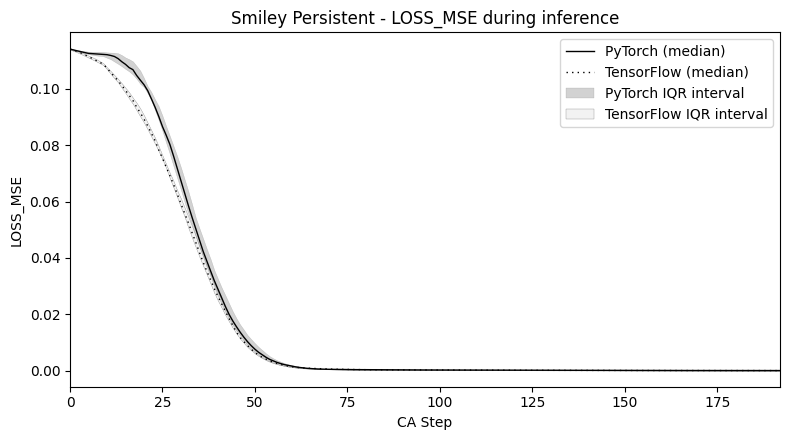


Metrics for smiley_persistent (loss_mse):
           avg_abs_gap: 0.001511308958910714
              rmse_gap: 0.003560323590773591
               max_gap: 0.012500274926424013
       step_at_max_gap: 21.0
      relative_gap_pct: 10.874553768547798
      avg_abs_gap_tail: 6.928840230078241e-06
     avg_abs_gap_64_96: 3.8469448389312124e-05
  iqr_overlap_fraction: 0.8341968911917098
        t_to_thresh_pt: 49
      t_to_thresh_gnca: 48
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.0004533832032007167
       gnca_mean_64_96: 0.0004726880014817167
          pt_mean_tail: 9.984471444110713e-05
        gnca_mean_tail: 9.29158742110289e-05


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


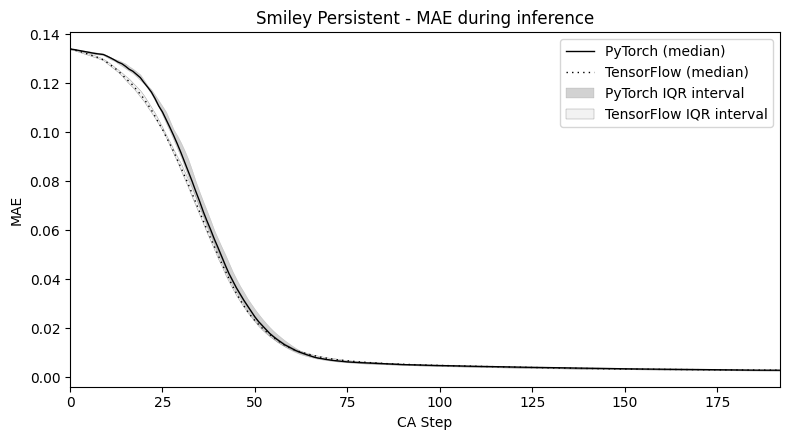

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_persistent (mae):
           avg_abs_gap: 0.0011026745532944932
              rmse_gap: 0.002265517868977023
               max_gap: 0.007284313440322904
       step_at_max_gap: 22.0
      relative_gap_pct: 2.803724066846766
      avg_abs_gap_tail: 3.142732020932767e-05
     avg_abs_gap_64_96: 0.0002847237117362773
  iqr_overlap_fraction: 0.844559585492228
        t_to_thresh_pt: 63
      t_to_thresh_gnca: 63
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.006165866902323786
       gnca_mean_64_96: 0.006450590614060064
          pt_mean_tail: 0.0029224416852229726
        gnca_mean_tail: 0.0029538690054323


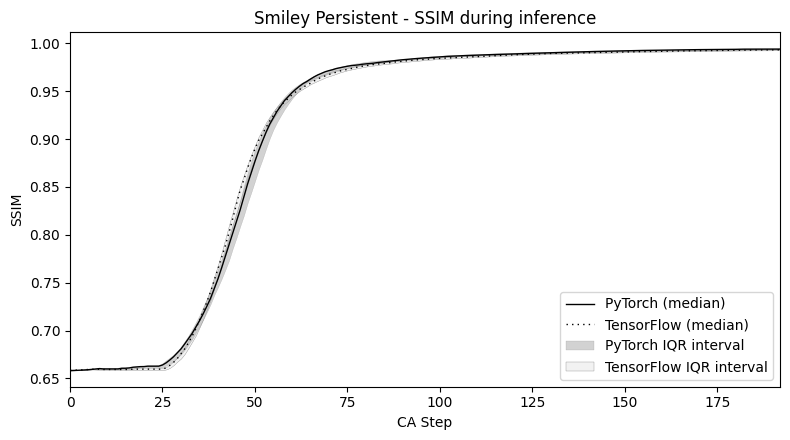

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_persistent (ssim):
           avg_abs_gap: 0.002603205195312503
              rmse_gap: 0.004331235477173828
               max_gap: 0.020537250000000062
       step_at_max_gap: 46.0
      relative_gap_pct: 0.3050369525033858
      avg_abs_gap_tail: 0.0009390534999999922
     avg_abs_gap_64_96: 0.002502891969696976
  iqr_overlap_fraction: 0.8186528497409327
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.977066176060606
       gnca_mean_64_96: 0.974563284090909
          pt_mean_tail: 0.9939790929999999
        gnca_mean_tail: 0.9930400395


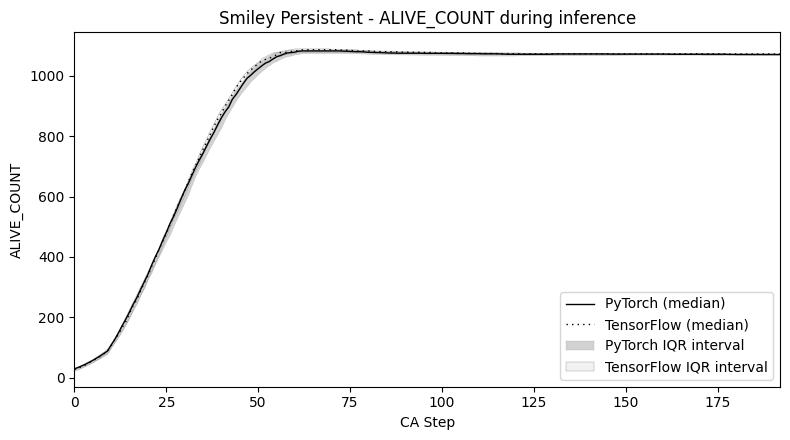

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_persistent (alive_count):
           avg_abs_gap: 3.7975260416666665
              rmse_gap: 6.075922105086876
               max_gap: 23.0
       step_at_max_gap: 44.0
      relative_gap_pct: 0.715928684734513
      avg_abs_gap_tail: 1.5
     avg_abs_gap_64_96: 3.5606060606060606
  iqr_overlap_fraction: 1.0
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 1079.090909090909
       gnca_mean_64_96: 1082.6515151515152
          pt_mean_tail: 1071.575
        gnca_mean_tail: 1073.075


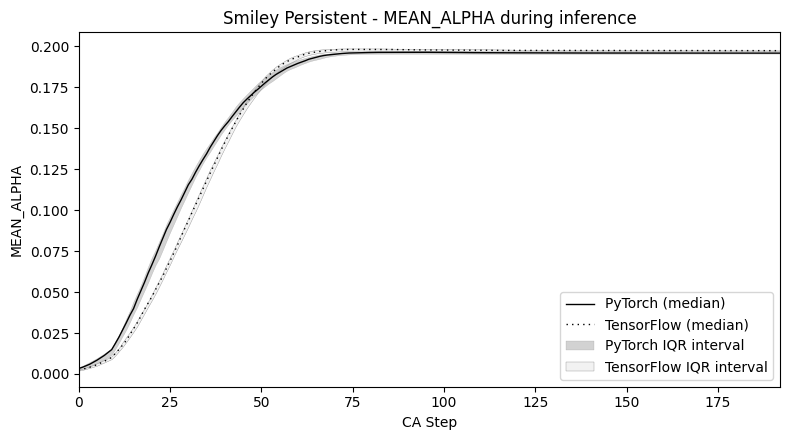

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_persistent (mean_alpha):
           avg_abs_gap: 0.0044389050596388745
              rmse_gap: 0.007456890716099448
               max_gap: 0.02372227981686595
       step_at_max_gap: 26.0
      relative_gap_pct: 7.0314228460306385
      avg_abs_gap_tail: 0.001507134363055236
     avg_abs_gap_64_96: 0.0020744082602587527
  iqr_overlap_fraction: 0.08808290155440414
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.1958182576027783
       gnca_mean_64_96: 0.19789266586303705
          pt_mean_tail: 0.19595036134123797
        gnca_mean_tail: 0.19745749570429322

Analyzing: smiley_regenerating


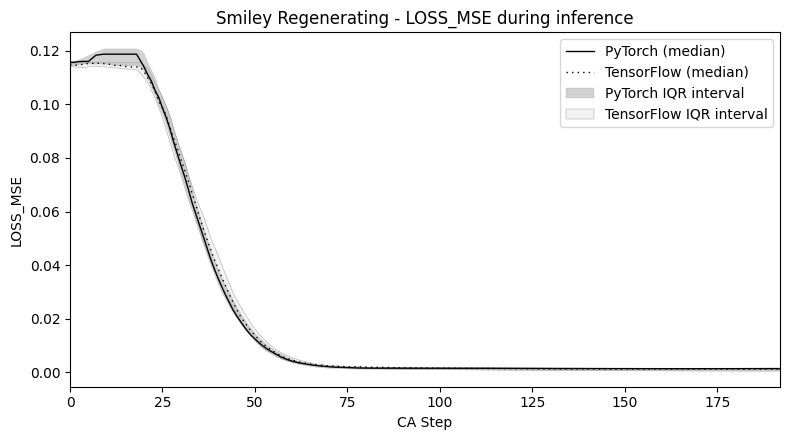

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_regenerating (loss_mse):
           avg_abs_gap: 0.0008043975302977428
              rmse_gap: 0.0014634689171107629
               max_gap: 0.0047578923404216905
       step_at_max_gap: 16.0
      relative_gap_pct: 8.663748347351424
      avg_abs_gap_tail: 0.00016151913878275002
     avg_abs_gap_64_96: 0.00025788099138122575
  iqr_overlap_fraction: 1.0
        t_to_thresh_pt: 53
      t_to_thresh_gnca: 53
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.0018223353474626195
       gnca_mean_64_96: 0.0020802163388438455
          pt_mean_tail: 0.001365461874229325
        gnca_mean_tail: 0.001203942735446575


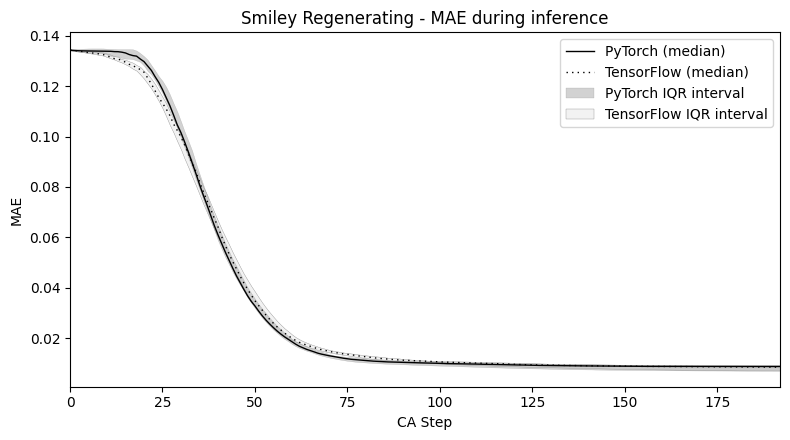

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_regenerating (mae):
           avg_abs_gap: 0.0011125504800778218
              rmse_gap: 0.001701599206259538
               max_gap: 0.006023690104484544
       step_at_max_gap: 24.0
      relative_gap_pct: 4.174962586173646
      avg_abs_gap_tail: 0.0001867681974545117
     avg_abs_gap_64_96: 0.001366784330457456
  iqr_overlap_fraction: 0.8082901554404145
        t_to_thresh_pt: 102
      t_to_thresh_gnca: 114
     delta_t_to_thresh: -12
         pt_mean_64_96: 0.011715403278217119
       gnca_mean_64_96: 0.013082187608674576
          pt_mean_tail: 0.008799933386035214
        gnca_mean_tail: 0.008613165188580702


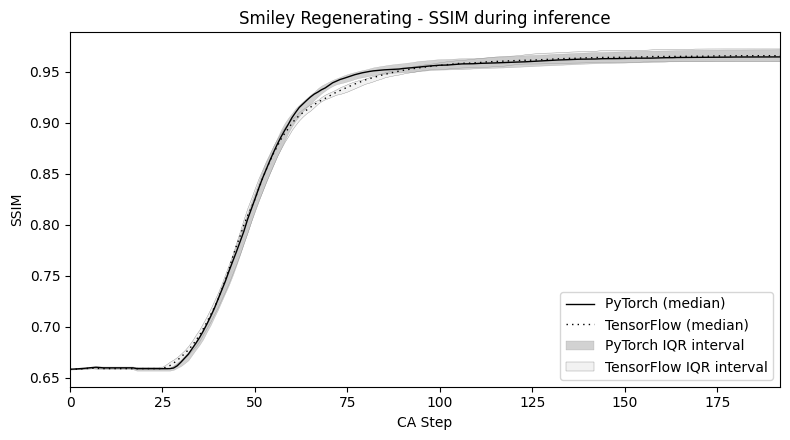

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_regenerating (ssim):
           avg_abs_gap: 0.0023497996028645917
              rmse_gap: 0.003654515058767454
               max_gap: 0.010959045000000112
       step_at_max_gap: 71.0
      relative_gap_pct: 0.26449604426210194
      avg_abs_gap_tail: 0.0012245140000000266
     avg_abs_gap_64_96: 0.006532167424242436
  iqr_overlap_fraction: 0.9015544041450777
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9454423574242424
       gnca_mean_64_96: 0.9389101899999999
          pt_mean_tail: 0.9643169011249999
        gnca_mean_tail: 0.9655414151249999


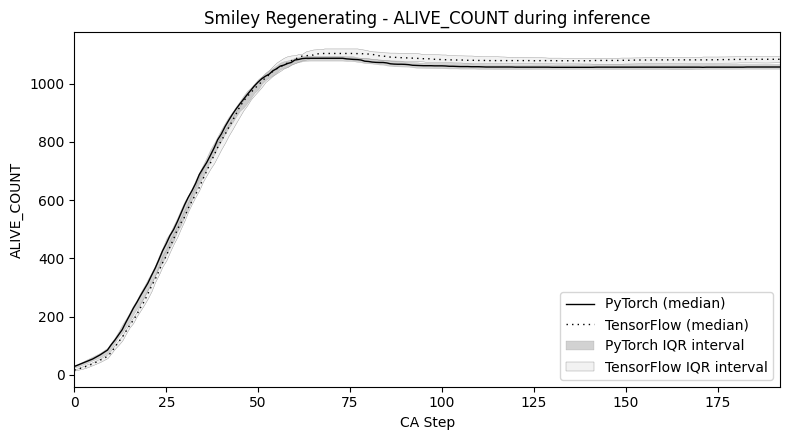

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_regenerating (alive_count):
           avg_abs_gap: 22.768229166666668
              rmse_gap: 24.170900311635062
               max_gap: 44.5
       step_at_max_gap: 34.0
      relative_gap_pct: 5.374513231726766
      avg_abs_gap_tail: 26.2125
     avg_abs_gap_64_96: 20.62121212121212
  iqr_overlap_fraction: 0.3316062176165803
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 1076.590909090909
       gnca_mean_64_96: 1097.2121212121212
          pt_mean_tail: 1057.25
        gnca_mean_tail: 1083.4625


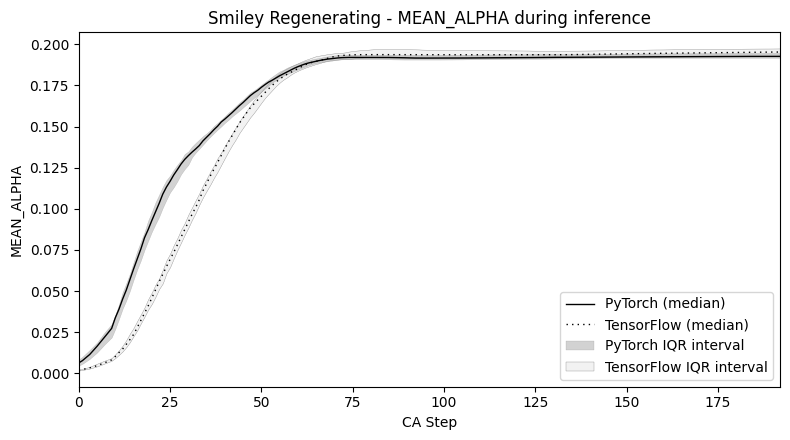

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for smiley_regenerating (mean_alpha):
           avg_abs_gap: 0.008438850048150924
              rmse_gap: 0.015885146254963872
               max_gap: 0.04868952371180061
       step_at_max_gap: 23.0
      relative_gap_pct: 15.438014098555575
      avg_abs_gap_tail: 0.0025066623464226763
     avg_abs_gap_64_96: 0.0014696152824343982
  iqr_overlap_fraction: 0.7409326424870466
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.19155481209357578
       gnca_mean_64_96: 0.1930079241142128
          pt_mean_tail: 0.19259494412690398
        gnca_mean_tail: 0.19510160647332664

Analyzing: web_growing


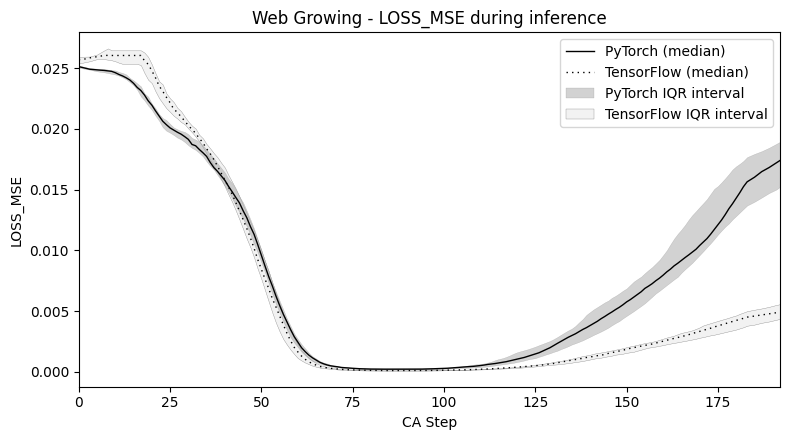

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_growing (loss_mse):
           avg_abs_gap: 0.00252815596786604
              rmse_gap: 0.00409223416241299
               max_gap: 0.012479967670515176
       step_at_max_gap: 192.0
      relative_gap_pct: 62.446098500292365
      avg_abs_gap_tail: 0.01050791581510566
     avg_abs_gap_64_96: 0.0001601122712600121
  iqr_overlap_fraction: 0.15544041450777202
        t_to_thresh_pt: 50
      t_to_thresh_gnca: 49
     delta_t_to_thresh: 1
         pt_mean_64_96: 0.00036106611382402725
       gnca_mean_64_96: 0.00020095384256401517
          pt_mean_tail: 0.014872116572223554
        gnca_mean_tail: 0.0043642007571178965


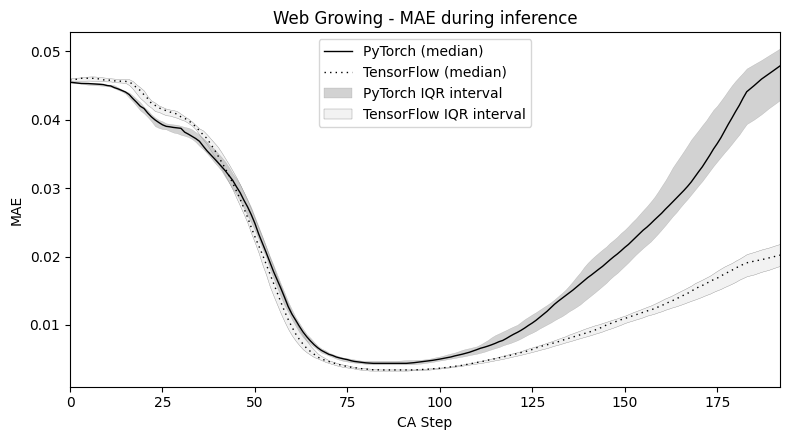

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_growing (mae):
           avg_abs_gap: 0.005976034162813453
              rmse_gap: 0.009518470278552372
               max_gap: 0.027668738272041075
       step_at_max_gap: 192.0
      relative_gap_pct: 34.82666350505259
      avg_abs_gap_tail: 0.02386505857575686
     avg_abs_gap_64_96: 0.0010664234057802847
  iqr_overlap_fraction: 0.15025906735751296
        t_to_thresh_pt: 62
      t_to_thresh_gnca: 60
     delta_t_to_thresh: 2
         pt_mean_64_96: 0.005083057782471589
       gnca_mean_64_96: 0.004016634376691305
          pt_mean_tail: 0.04247374660335477
        gnca_mean_tail: 0.0186086880275979


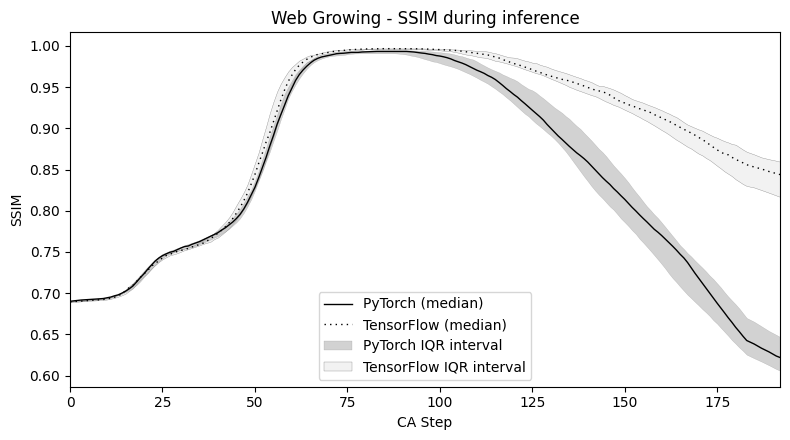

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_growing (ssim):
           avg_abs_gap: 0.05502853702473958
              rmse_gap: 0.08934940224043733
               max_gap: 0.22192691999999992
       step_at_max_gap: 192.0
      relative_gap_pct: 6.731147743561569
      avg_abs_gap_tail: 0.20632127299999997
     avg_abs_gap_64_96: 0.003980239999999999
  iqr_overlap_fraction: 0.2849740932642487
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9905157840909091
       gnca_mean_64_96: 0.9944960240909092
          pt_mean_tail: 0.65283667575
        gnca_mean_tail: 0.8591579487500001


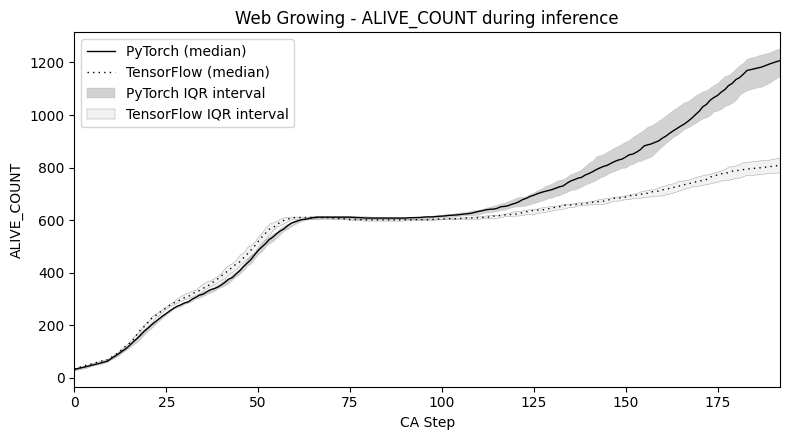

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_growing (alive_count):
           avg_abs_gap: 85.75520833333333
              rmse_gap: 141.55373754153993
               max_gap: 398.5
       step_at_max_gap: 192.0
      relative_gap_pct: 11.882466484715684
      avg_abs_gap_tail: 355.7
     avg_abs_gap_64_96: 6.151515151515151
  iqr_overlap_fraction: 0.20725388601036268
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 609.2121212121212
       gnca_mean_64_96: 603.2727272727273
          pt_mean_tail: 1145.825
        gnca_mean_tail: 790.125


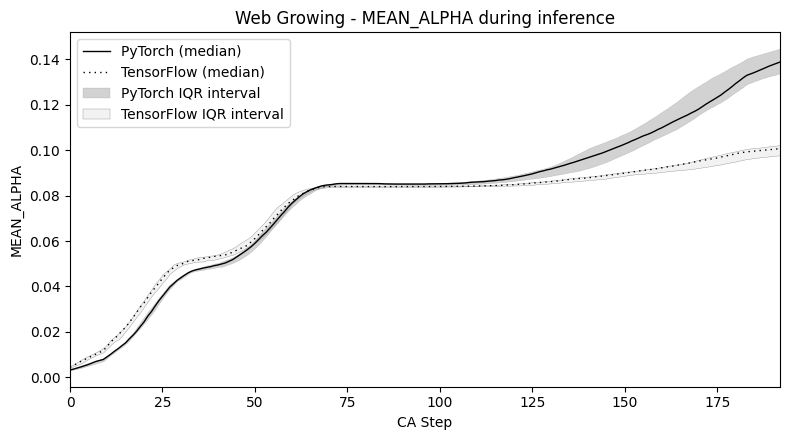

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_growing (mean_alpha):
           avg_abs_gap: 0.008367958611415816
              rmse_gap: 0.012883534504683703
               max_gap: 0.03815319202840328
       step_at_max_gap: 192.0
      relative_gap_pct: 12.6833410640523
      avg_abs_gap_tail: 0.032334547024220235
     avg_abs_gap_64_96: 0.0010298991745168382
  iqr_overlap_fraction: 0.11398963730569948
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08482983301986345
       gnca_mean_64_96: 0.08381066584225855
          pt_mean_tail: 0.13107489310204978
        gnca_mean_tail: 0.09874034607782955

Analyzing: web_persistent


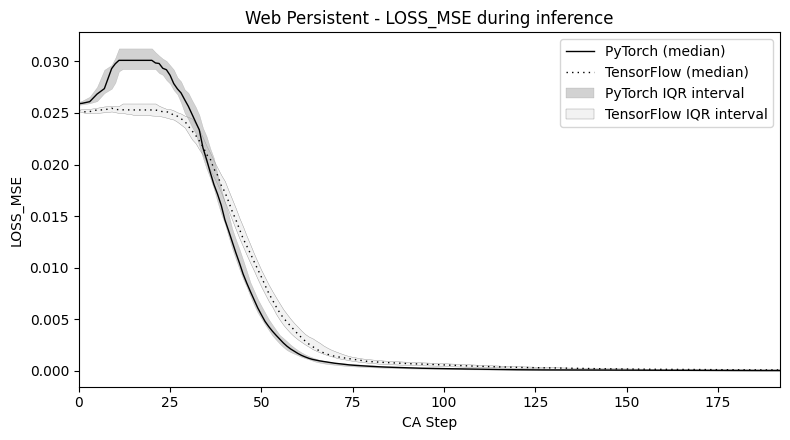


Metrics for web_persistent (loss_mse):
           avg_abs_gap: 0.0011209287170264588
              rmse_gap: 0.0018275297523219136
               max_gap: 0.004805332981049949
       step_at_max_gap: 14.0
      relative_gap_pct: 67.49800499710118
      avg_abs_gap_tail: 7.038251869740861e-05
     avg_abs_gap_64_96: 0.0005658035196106425
  iqr_overlap_fraction: 0.05181347150259067
        t_to_thresh_pt: 45
      t_to_thresh_gnca: 49
     delta_t_to_thresh: -4
         pt_mean_64_96: 0.0005229289749739045
       gnca_mean_64_96: 0.001088732494584547
          pt_mean_tail: 4.0976742911880135e-05
        gnca_mean_tail: 0.00011135926160928875


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


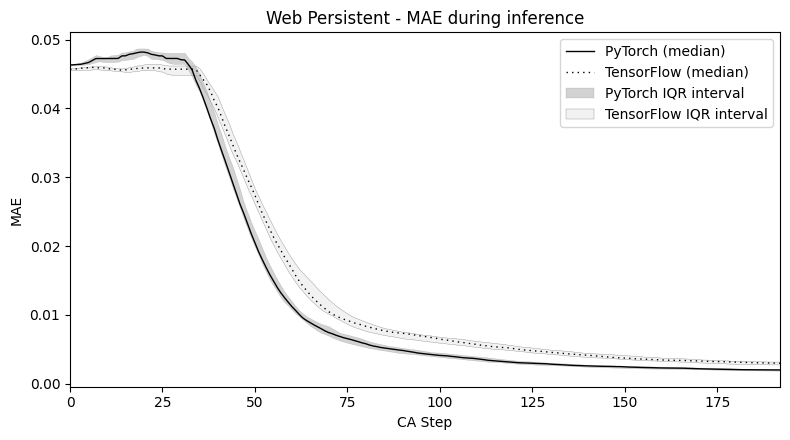

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_persistent (mae):
           avg_abs_gap: 0.0023329227868392403
              rmse_gap: 0.0027963122264389453
               max_gap: 0.006911076605319949
       step_at_max_gap: 50.0
      relative_gap_pct: 32.54808729397221
      avg_abs_gap_tail: 0.0010550066275754938
     avg_abs_gap_64_96: 0.0027952852701260255
  iqr_overlap_fraction: 0.031088082901554404
        t_to_thresh_pt: 63
      t_to_thresh_gnca: 72
     delta_t_to_thresh: -9
         pt_mean_64_96: 0.0060971357408120316
       gnca_mean_64_96: 0.008892421010938057
          pt_mean_tail: 0.0020317030546720574
        gnca_mean_tail: 0.003086709682247551


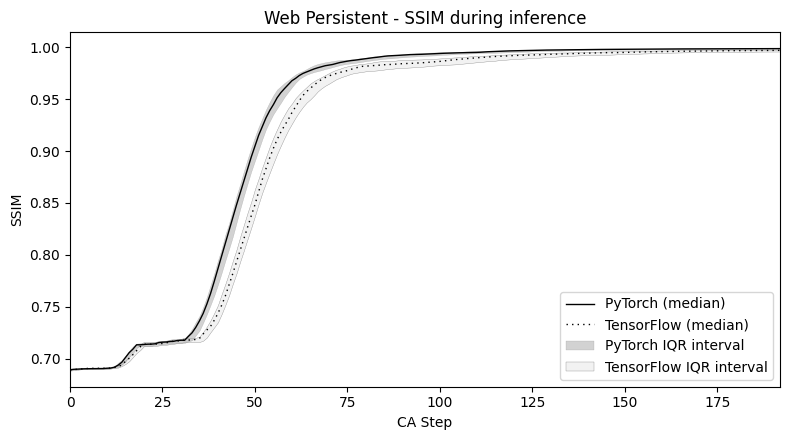

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_persistent (ssim):
           avg_abs_gap: 0.009999788867187507
              rmse_gap: 0.017627090749738894
               max_gap: 0.05661509000000009
       step_at_max_gap: 49.0
      relative_gap_pct: 1.120305264729846
      avg_abs_gap_tail: 0.0018210685000000504
     avg_abs_gap_64_96: 0.009539011060606032
  iqr_overlap_fraction: 0.16062176165803108
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.987759322878788
       gnca_mean_64_96: 0.9782203118181817
          pt_mean_tail: 0.9986045640000001
        gnca_mean_tail: 0.9967834955000001


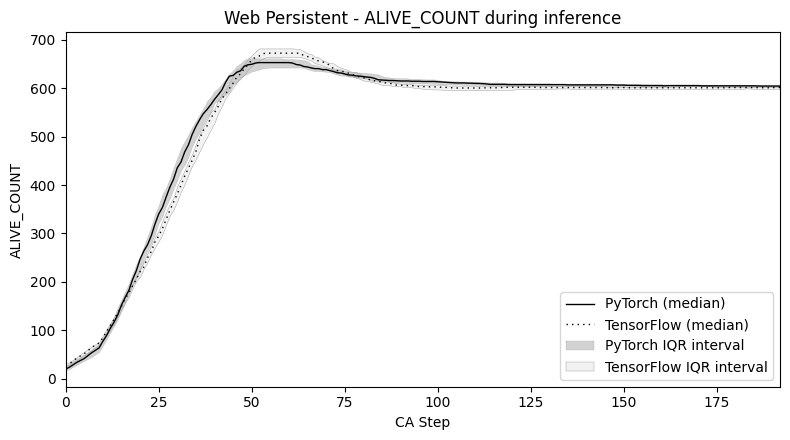

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_persistent (alive_count):
           avg_abs_gap: 11.689453125
              rmse_gap: 16.62270406295508
               max_gap: 54.0
       step_at_max_gap: 30.0
      relative_gap_pct: 3.5827534620788755
      avg_abs_gap_tail: 3.5625
     avg_abs_gap_64_96: 8.636363636363637
  iqr_overlap_fraction: 0.27461139896373055
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 625.7272727272727
       gnca_mean_64_96: 627.060606060606
          pt_mean_tail: 604.8375
        gnca_mean_tail: 601.275


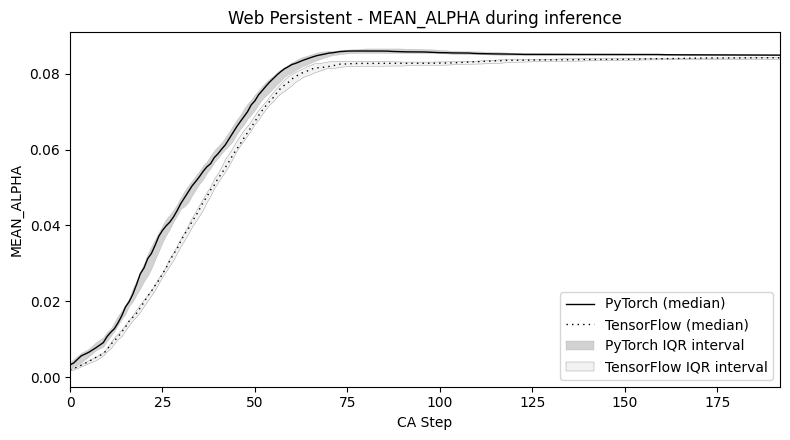

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_persistent (mean_alpha):
           avg_abs_gap: 0.003258416898991831
              rmse_gap: 0.004208373020742477
               max_gap: 0.011630089953541756
       step_at_max_gap: 24.0
      relative_gap_pct: 9.216847327175339
      avg_abs_gap_tail: 0.0007514259777963168
     avg_abs_gap_64_96: 0.003221151390762034
  iqr_overlap_fraction: 0.0
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08568338982083576
       gnca_mean_64_96: 0.08246223843007372
          pt_mean_tail: 0.08499039411544798
        gnca_mean_tail: 0.08423896813765164

Analyzing: web_regenerating


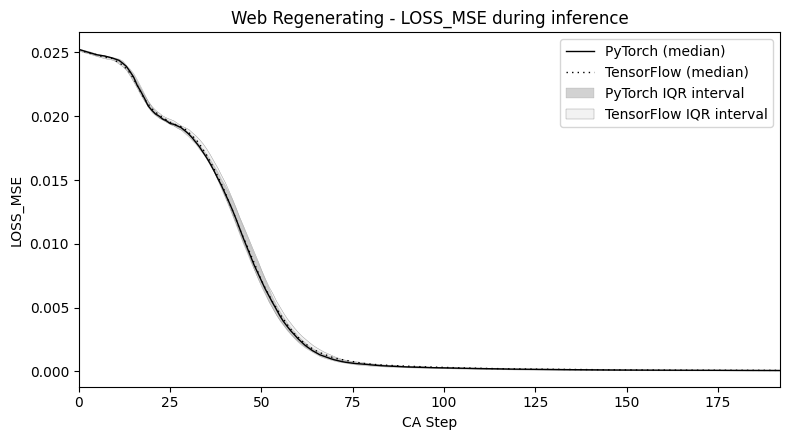

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_regenerating (loss_mse):
           avg_abs_gap: 5.777019320873875e-05
              rmse_gap: 8.13320431795864e-05
               max_gap: 0.0002321926876902511
       step_at_max_gap: 32.0
      relative_gap_pct: 7.668634933499077
      avg_abs_gap_tail: 8.561886534153019e-06
     avg_abs_gap_64_96: 9.248043484562272e-05
  iqr_overlap_fraction: 1.0
        t_to_thresh_pt: 46
      t_to_thresh_gnca: 46
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.0006407240562662545
       gnca_mean_64_96: 0.0007332044911118773
          pt_mean_tail: 7.885114309829078e-05
        gnca_mean_tail: 8.74130296324438e-05


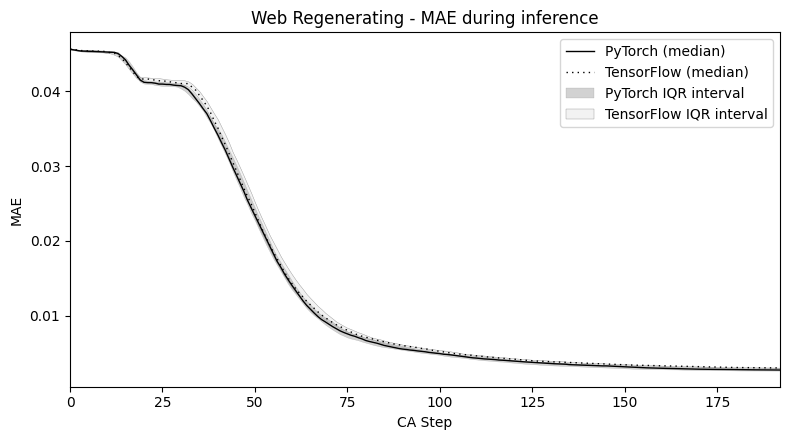

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_regenerating (mae):
           avg_abs_gap: 0.00035788316260247334
              rmse_gap: 0.0004085741051578485
               max_gap: 0.001153411343693747
       step_at_max_gap: 34.0
      relative_gap_pct: 5.604971617814753
      avg_abs_gap_tail: 0.0002817047556163751
     avg_abs_gap_64_96: 0.0004806119426520453
  iqr_overlap_fraction: 0.6424870466321243
        t_to_thresh_pt: 67
      t_to_thresh_gnca: 69
     delta_t_to_thresh: -2
         pt_mean_64_96: 0.00720771723850202
       gnca_mean_64_96: 0.007688329181154064
          pt_mean_tail: 0.002794513539993151
        gnca_mean_tail: 0.003076218295609526


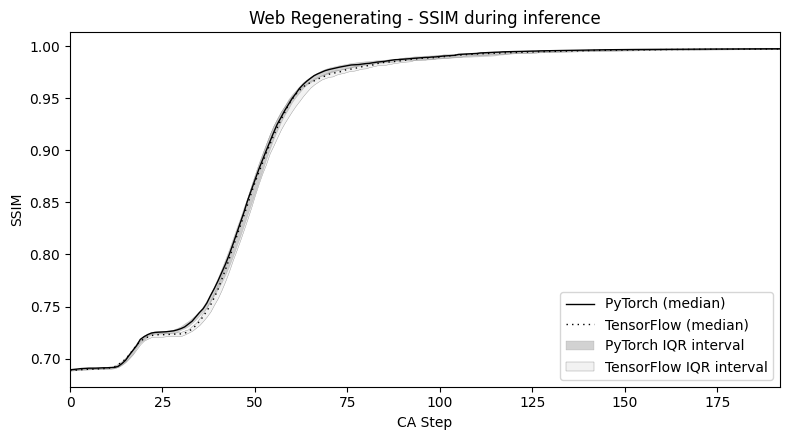

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_regenerating (ssim):
           avg_abs_gap: 0.001707093984374998
              rmse_gap: 0.0026187512314594335
               max_gap: 0.009170310000000015
       step_at_max_gap: 38.0
      relative_gap_pct: 0.2012359375962699
      avg_abs_gap_tail: 0.00023951337499996672
     avg_abs_gap_64_96: 0.002651906363636362
  iqr_overlap_fraction: 0.927461139896373
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.9822366672727273
       gnca_mean_64_96: 0.9795847609090909
          pt_mean_tail: 0.9975567771249997
        gnca_mean_tail: 0.9973172637500001


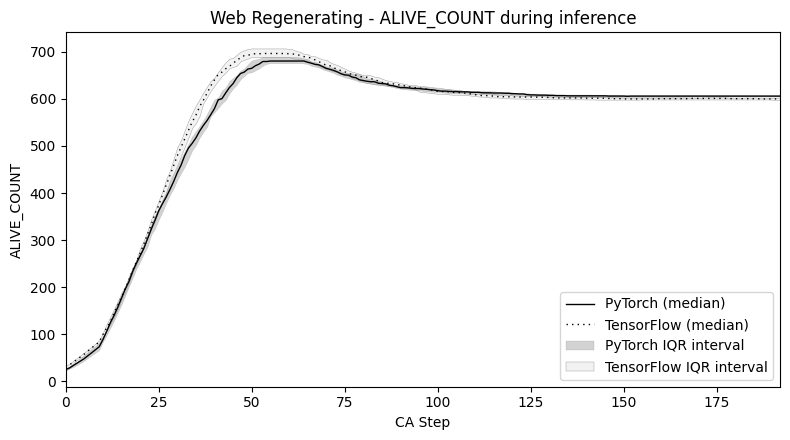

/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))



Metrics for web_regenerating (alive_count):
           avg_abs_gap: 10.965494791666666
              rmse_gap: 17.151833258126764
               max_gap: 61.0
       step_at_max_gap: 39.0
      relative_gap_pct: 2.8503971896193594
      avg_abs_gap_tail: 5.525
     avg_abs_gap_64_96: 5.5
  iqr_overlap_fraction: 0.44041450777202074
        t_to_thresh_pt: nan
      t_to_thresh_gnca: nan
     delta_t_to_thresh: nan
         pt_mean_64_96: 644.6060606060606
       gnca_mean_64_96: 650.1060606060606
          pt_mean_tail: 606.0
        gnca_mean_tail: 600.475


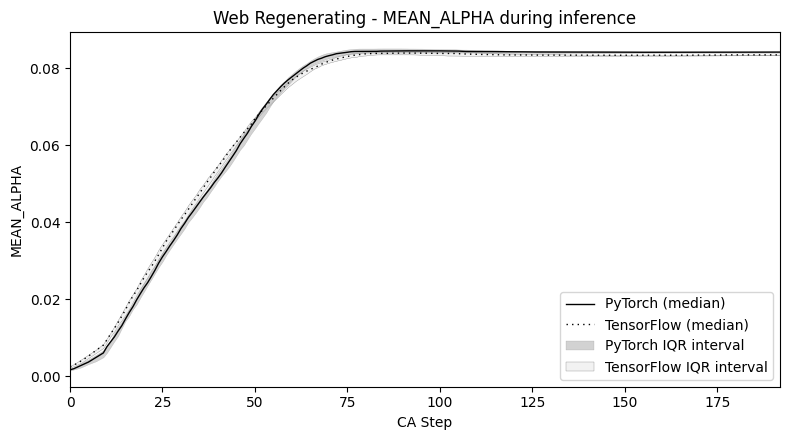


Metrics for web_regenerating (mean_alpha):
           avg_abs_gap: 0.0011523136214842996
              rmse_gap: 0.0013449405550738985
               max_gap: 0.0029625594615936
       step_at_max_gap: 40.0
      relative_gap_pct: 4.18437839194287
      avg_abs_gap_tail: 0.0007194967009126925
     avg_abs_gap_64_96: 0.000931379469958212
  iqr_overlap_fraction: 0.29015544041450775
        t_to_thresh_pt: 0
      t_to_thresh_gnca: 0
     delta_t_to_thresh: 0
         pt_mean_64_96: 0.08389881162932422
       gnca_mean_64_96: 0.082967432159366
          pt_mean_tail: 0.08421378955245014
        gnca_mean_tail: 0.08349429285153744


/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aag = np.trapz(adiff, g) / (g[-1] - g[0])
/var/folders/8g/ghr7q31x1pdgybtjx34c4cv40000gn/T/ipykernel_49654/687472577.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  rmse = np.sqrt(np.trapz(diff**2, g) / (g[-1] - g[0]))


In [179]:
# Cell 5: Generate plots for all target/mode combinations
os.makedirs('figures', exist_ok=True)

all_metrics = {}

for key in sorted(grouped_pt.keys()):
    print(f"\n{'='*60}")
    print(f"Analyzing: {key}")
    print(f"{'='*60}")
    
    pt_data = grouped_pt[key]
    gnca_data = grouped_gnca[key]
    
    # Plot for each available metric
    available_metrics = set()
    for df in pt_data + gnca_data:
        available_metrics.update(df.columns)
    
    plot_metrics = ['loss_mse', 'mae', 'ssim', 'alive_count', 'mean_alpha']  # Add other metrics as needed
    available_plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    all_metrics[key] = {}
    for metric in available_plot_metrics:
        try:
            metrics = make_inference_plot(pt_data, gnca_data, key, metric)
            if metrics:
                all_metrics[key][metric] = metrics
        except Exception as e:
            print(f"Error plotting {metric} for {key}: {e}")

In [180]:
# Cell 6: Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_df_data = []
for key, metrics_dict in all_metrics.items():
    target, mode = parse_run_name(key + "_dummy")  # Extract target and mode
    for metric, metrics in metrics_dict.items():
        summary_df_data.append({
            'target': target,
            'mode': mode,
            'target_mode': key,
            'metric': metric,
            # include the actual value
            
            'avg_abs_gap': metrics['avg_abs_gap'],
            'avg_abs_gap_64_96': metrics['avg_abs_gap_64_96'],
            'avg_abs_gap_tail': metrics['avg_abs_gap_tail'],
            'max_gap': metrics['max_gap'],
            'rmse_gap': metrics['rmse_gap'],
            'relative_gap_pct': metrics['relative_gap_pct'],
            'iqr_overlap_fraction': metrics['iqr_overlap_fraction'],
            'pt_mean_64_96': metrics['pt_mean_64_96'],
            'gnca_mean_64_96': metrics['gnca_mean_64_96'],
            'pt_mean_tail': metrics['pt_mean_tail'],
            'gnca_mean_tail': metrics['gnca_mean_tail'],
        })

if summary_df_data:
    summary_df = pd.DataFrame(summary_df_data)
    
    # Get all unique evaluation metrics
    unique_metrics = summary_df['metric'].unique()
    
    # Create separate table for each evaluation metric
    for eval_metric in sorted(unique_metrics):
        print(f"\n{'='*60}")
        print(f"PERFORMANCE GAPS FOR {eval_metric.upper()}")
        print(f"{'='*60}")
        
        # Filter data for this specific metric
        metric_data = summary_df[summary_df['metric'] == eval_metric].copy()
        
        # Create pivot table with mode+target as index and gap metrics as columns
        pivot_table = metric_data.pivot_table(
            index=['mode', 'target'], 
            # values=['avg_abs_gap', 'avg_abs_gap_64_96', 'rmse_gap', 'relative_gap_pct', 'iqr_overlap_fraction', 'avg_abs_gap_tail', 'max_gap', 'pt_mean', 'gnca_mean'],
            values=['pt_mean_64_96', 'pt_mean_tail', 'gnca_mean_64_96', 'gnca_mean_tail'],
            aggfunc='mean'
        )
        
        print(pivot_table)
        
        # Also save individual CSV for each metric
        pivot_table.to_csv(f'inference_gaps_{eval_metric}.csv')
        print(f"Saved to inference_gaps_{eval_metric}.csv")
    
    # Overall summary across all metrics
    print(f"\n{'='*60}")
    print("OVERALL SUMMARY (averaged across all metrics)")
    print(f"{'='*60}")

    # overall_summary = summary_df.groupby(['mode', 'target'])[['avg_abs_gap', 'avg_abs_gap_64_96', 'rmse_gap', 'relative_gap_pct', 'iqr_overlap_fraction', 'avg_abs_gap_tail', 'max_gap', 'pt_mean', 'gnca_mean']].mean()
    overall_summary = summary_df.groupby(['mode', 'target'])[['pt_mean_64_96', 'pt_mean_tail', 'gnca_mean_64_96', 'gnca_mean_tail']].mean()
    print(overall_summary)
    
    # Save complete summary
    summary_df.to_csv('inference_comparison_summary_detailed.csv', index=False)
    overall_summary.to_csv('inference_comparison_summary_overall.csv')
    print("\nDetailed summary saved to inference_comparison_summary_detailed.csv")
    print("Overall summary saved to inference_comparison_summary_overall.csv")


SUMMARY STATISTICS

PERFORMANCE GAPS FOR ALIVE_COUNT
                      gnca_mean_64_96  gnca_mean_tail  pt_mean_64_96  \
mode         target                                                    
growing      fish          805.424242        852.2375     810.106061   
             ladybug       776.590909        790.6625     780.575758   
             lizard        521.712121        549.9625     519.621212   
             smiley       1085.924242       1794.6750    1075.500000   
             web           603.272727        790.1250     609.212121   
persistent   fish          814.666667        807.0000     810.454545   
             ladybug       802.666667        771.1000     784.803030   
             lizard        526.303030        518.1000     526.636364   
             smiley       1082.651515       1073.0750    1079.090909   
             web           627.060606        601.2750     625.727273   
regenerating fish          854.287879        822.6500     818.893939   
          